# Introduction
State notebook purpose here

### Imports
Import libraries and write settings here.

In [1]:
# Notebooks specific imports
from IPython import get_ipython
ipython = get_ipython()
#Expand notebook display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload
%autoreload 2
from tqdm.notebook import tqdm

# Basic useful imports
import re
import time
import yaml
from pprint import pprint
from pathlib import Path
import h5py
import gc
import pickle as pkl

# Data manipulation
import numpy as np
from scipy.optimize import curve_fit
from scipy.special import erf
from scipy.integrate import quad
from scipy.signal import savgol_filter
from scipy import fftpack
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import (Circle, RegularPolygon, FancyArrowPatch, ArrowStyle)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, NullFormatter)
import matplotlib.colors as mcolors
import matplotlib.colors as colors

# From alens_analysis.py
import alens_analysis as aa
from alens_analysis.colormaps import register_cmaps
import alens_analysis.chromatin as aac
import alens_analysis.chromatin.chrom_analysis as ca
import alens_analysis.chromatin.chrom_condensate_analysis as cca
import alens_analysis.chromatin.chrom_graph_funcs as cgf
from alens_analysis import cluster_analysis as cla

# Locations
ws_path = Path('/home/alamson/DATA/Chromatin/')
mnt_path = Path.home() / 'projects/DATA/Chromatin/'
ceph_path = Path.home() / 'ceph/DATA/Chromatin/'

cuda


In [2]:
torch.__version__

import warnings

warnings.filterwarnings('ignore')

'1.13.0'

### Style settings

In [3]:
graph_sty = {
    "axes.titlesize": 20,
    "axes.labelsize": 24,
    "lines.linewidth": 2,
    "lines.markersize": 2,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "font.size": 20,
    "font.sans-serif": 'Helvetica',
    "text.usetex": False,
    'mathtext.fontset': 'cm',
}
plt.style.use(graph_sty)

register_cmaps()
plt.rcParams['image.cmap'] = 'YlOrRd'
#plt.rcParams['image.cmap'] = 'emct8'
#plt.rcParams['image.cmap'] = 'warm'
#plt.rcParams['image.cmap'] = 'twilight'
#plt.rcParams['image.cmap'] = 'coolwarm'
#plt.rcParams['image.cmap'] = 'RdYlBu_r'
        

# Functions

In [4]:
def poly_bead_rmsd(com_arr):
    # avg_rog = (aa.calc_rad_of_gyration(com_arr)).mean()
    tcom_arr = torch.from_numpy(com_arr).to(device)
    n = com_arr.shape[0]
    Ttot = com_arr.shape[-1]
    pol_com = tcom_arr.mean(axis=0)
    rmsd = torch.zeros(Ttot, device=device)
    for i in range(1,Ttot):
        tdiff_mat = (tcom_arr[:,:,i:] - pol_com[:,i:]) - (tcom_arr[:,:,:-i] - pol_com[:,:-i])
        rmsd[i] = torch.einsum('ijk,ijk->', tdiff_mat, tdiff_mat)/((Ttot-i)*n)
        
    return rmsd


In [5]:
def poly_autocorr(com_arr):
    avg_rog = (aa.calc_rad_of_gyration(com_arr)).mean()
    tcom_arr = torch.from_numpy(com_arr).to(device)
    n = com_arr.shape[0]
    Ttot = com_arr.shape[-1]
    pol_com = tcom_arr.mean(axis=0).to(device)
    autocorr = torch.zeros(Ttot, device=device)
    for i in range(1,Ttot):
        autocorr[i] = ((tcom_arr[:,:,i:] - pol_com[:,i:])* 
                                (tcom_arr[:,:,:-i] - pol_com[:,:-i])).sum()/((Ttot-i)*(avg_rog*avg_rog)*n)
        
    return autocorr


In [6]:
def next_pow_two(n):
    i = 1
    while i < n:
        i = i << 1
    return i

def poly_autocorr_fast(com_arr):
    # avg_rog = (aa.calc_rad_of_gyration(com_arr)).mean()
    tcom_arr = torch.from_numpy(com_arr).to(device)
    pol_com = tcom_arr.mean(dim=0).to(device)
    nsteps = tcom_arr.shape[-1]
    n = next_pow_two(nsteps)

    # Compute the FFT and then (from that) the auto-correlation function
    f = torch.fft.fftn(tcom_arr-pol_com, dim=[-1], norm='forward')
    power_spec = torch.einsum('ijk,ijk->ik', f, torch.conj(f))
    autocorr = torch.fft.ifftn(power_spec, norm='forward', dim=[-1])[:,:nsteps].real
    return autocorr.mean(dim=0)

def poly_dist_autocorr_fast(com_arr):
    # avg_rog = (aa.calc_rad_of_gyration(com_arr)).mean()
    tcom_arr = torch.from_numpy(com_arr).to(device)
    pol_com = tcom_arr.mean(dim=0).to(device)
    nsteps = tcom_arr.shape[-1]
    n = next_pow_two(nsteps)
    tcom_dist = torch.norm(tcom_arr-pol_com, dim=1)

    # Compute the FFT and then (from that) the auto-correlation function
    f = torch.fft.fftn(tcom_dist, dim=[-1], norm='forward')
    power_spec = torch.einsum('ik,ik->ik', f, torch.conj(f))
    autocorr = torch.fft.ifftn(power_spec, norm='forward', dim=[-1])[:,:nsteps].real
    return autocorr.mean(dim=0)
        


In [7]:
def sep_autocorr(com_arr):
    tcom_arr = torch.from_numpy(com_arr).to(device)
    tsep_mat = (tcom_arr[:, None, :,:] - tcom_arr[None, :, :,:]).norm(dim=2).to(device)
    n = tsep_mat.shape[0]
    Ttot = tsep_mat.shape[-1]
    tcorr_d = torch.zeros(tsep_mat.shape[-1], device=device)
    avg_tsep_mat = tsep_mat.mean(dim=(0,1)).to(device)
    avg_sep = avg_tsep_mat.mean()
    for i in range(1,tsep_mat.shape[-1]):
        tcorr_d[i] = ((tsep_mat[:,:,i:] - avg_tsep_mat[i:]) * (tsep_mat[:,:,:-i]-avg_tsep_mat[:-i])).sum()/(n*n*avg_sep*avg_sep*(Ttot-i))
        
    return tcorr_d


In [8]:

def autocorr_fast(com_arr):
    tcom_arr = torch.from_numpy(com_arr).to(device)
    t0 = time.time()
    tsep_mat = (tcom_arr[:, None, :,:] - tcom_arr[None, :, :,:]).norm(dim=2).to(device)
    t1 = time.time()
    print(f'tsep_mat = {t1-t0}')
    nsteps = tsep_mat.shape[-1]
    n = next_pow_two(nsteps)
    t2 = time.time()
    print(f'power of two = {t2-t1}')

    # Compute the FFT and then (from that) the auto-correlation function
    f = torch.fft.fftn(tsep_mat, s=[2 * n], dim=[-1])
    t3 = time.time()
    print(f'fft = {t3-t2}')
    autocorr = torch.fft.ifftn(torch.einsum('ijk,ijk->ik', f,
                                       torch.conjugate(f)),
                             dim=[-1])[:nsteps].real
    t4 = time.time()
    print(f'ifft = {t4-t3}')

    autocorr /= 4 * n
    return autocorr


In [9]:
def monoExp(x, m, a):
    return m * np.exp(-a * x)

def negmonoExp(x, m, a):
    return m*(1. - np.exp(-a * x))

def line_func(x, a, b):
    return a*x + b

def fit_curve(x, y, fit_func):
    params, cv = curve_fit(fit_func, x, y)
    #print(params)
    squaredDiffs = np.square(y - fit_func(x, *params))
    squaredDiffsFromMean = np.square(y - np.mean(y))
    SEM = np.sqrt(np.sum(squaredDiffs))/x.size
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
    #print(f"R² = {rSquared}")

    return params, rSquared, SEM
def func_powerlaw(x, a, b, c):
    return a + b * np.power(x,c)

def func_powerlaw_zero(x, a, b, c):
    return b * np.power(x,c)

def rsqr_val(func, x, y, popts):
    residuals = y - func(x, *popts)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y-np.mean(y))**2)
    return 1. - (ss_res / ss_tot)

In [10]:
def find_steady_state_ind(arr, avg_inv=(0,None)):
    """Find the first time an array reaches an average value given an interval
    to average over (usually the end of the array).

    Parameters
    ----------
    arr : _type_
        _description_
    avg_inv : tuple, optional
        _description_, by default (0,None)
    """
    arr = np.array(arr)
    avg = arr[avg_inv[0]:avg_inv[1]].mean()
    if avg > arr[0]:
        return (arr >= avg).nonzero()[0]
    return (arr <= avg).nonzero()[0][0]



# Seed scan

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


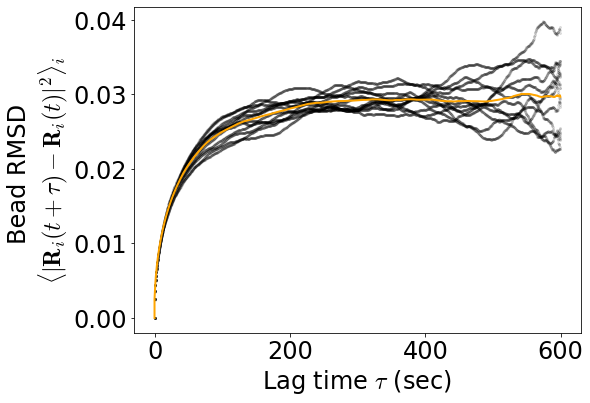

In [8]:
data_path = (ceph_path /"CondCharPaper/22-10-16_aLc1_line800_sticky55nm_kod.1-300/simulations/kod30")
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
ss_ind = 1200
end_ind = -1
start_bead = 0
end_bead = None

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

try:
    seed_paths = [path for path in data_path.glob('**/s*') if path.is_dir()]
    assert seed_paths
    
    rmsd_list = []
    for sp in seed_paths:
        with h5py.File(next(sp.glob('analysis/raw*.h5')), 'r+') as h5_data:
            lag_arr = h5_data['time'][:-ss_ind+end_ind]

            sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                                :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            rmsd_list += [poly_bead_rmsd(com_arr)]

            _ = axarr.scatter(lag_arr, rmsd_list[-1].cpu(), color='k',alpha=.1)

    min_length = min([arr.shape[-1] for arr in rmsd_list])
    rmsd_avg = torch.stack([arr[:min_length] for arr in rmsd_list]).mean(dim=0)
    
    
        
    _ = axarr.plot(lag_arr[:min_length], rmsd_avg.cpu(), color='orange')
    _ = axarr.set_xlabel(r'Lag time $\tau$ (sec)')
    _ = axarr.set_ylabel('Bead RMSD \n' + r'$\langle |{\bf R}_i(t+\tau)- {\bf R}_i(t)|^2 \rangle_i$')
        
except:
    raise

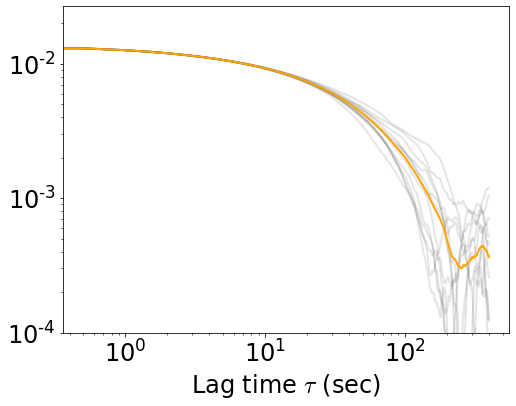

In [28]:
data_path = (ceph_path /"CondCharPaper/22-10-16_aLc1_line800_sticky55nm_kod.1-300/simulations/kod30")
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
ss_ind = -1600
end_ind = -1
start_bead = 0
end_bead = None


try:
    seed_paths = [path for path in data_path.glob('**/s*') if path.is_dir()]
    assert seed_paths
    
    corr_list = []
    for sp in seed_paths:
        with h5py.File(next(sp.glob('analysis/raw*.h5')), 'r+') as h5_data:
            valid_n = int((-ss_ind+end_ind)/2)
            lag_arr = h5_data['time'][:valid_n]

            sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                                :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            corr_list  += [poly_autocorr_fast(com_arr)[:valid_n]]
            # fft = torch.fft.fft(com_arr, dim=-1)
            # power_spec = torch.einsum('ijk,ijk->ik', fft, torch.conj(fft)) 
            # n_beads = com_arr.shape[0]
            # corr_list  += [torch.fft.ifft(power_spec,dim=-1).mean(dim=0)]

            # corr_list += [torch.fft.fftshift(power_spec.mean(axis=0))]
            # freq = torch.fft.fftfreq(corr_list[-1].size(dim=0), lag_arr[2]-lag_arr[1])
            # freqs = torch.fft.fftshift(freq)
            # _ = axarr1[0].plot(freqs, power_spec_list[-1].cpu(), color=colors[i], alpha=.1)
            # corr_list  += [power_spec.mean(dim=0)]

            # power_spec = [torch.fft.fftshift(power_spec.mean(axis=0))]
            # freq = torch.fft.fftfreq(power_spec_list[-1].size(dim=0), time_arr[2]-time_arr[1])
            # freqs = torch.fft.fftshift(freq)
            _ = axarr.plot(lag_arr, corr_list[-1].cpu(), color='k', alpha=.1)
            # rmsd_list += [poly_bead_rmsd(com_arr)]


    min_length = min([arr.shape[-1] for arr in corr_list])
    corr_avg = torch.stack([arr[:min_length] for arr in corr_list]).mean(dim=0)
    
    
        
    _ = axarr.plot(lag_arr[:min_length], corr_avg.cpu(), color='orange')
    _ = axarr.set_xlabel(r'Lag time $\tau$ (sec)')
    _ = axarr.set_yscale('log')
    _ = axarr.set_ylim(.0001)
    _ = axarr.set_xscale('log')
    # _ = axarr.set_ylabel('Bead RMSD \n' + r'$\langle |{\bf R}_i(t+\tau)- {\bf R}_i(t)|^2 \rangle_i$')
        
except:
    raise

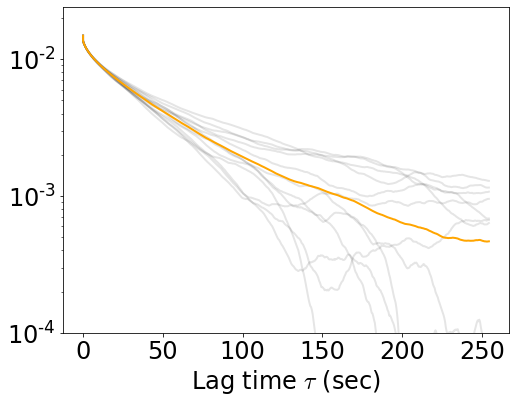

In [15]:
data_path = (ceph_path /"CondCharPaper/22-10-16_aLc1_line800_sticky55nm_kod.1-300/simulations/kod30")
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
ss_ind = -1023
end_ind = -1
start_bead = 0
end_bead = None


try:
    seed_paths = [path for path in data_path.glob('**/s*') if path.is_dir()]
    assert seed_paths
    
    corr_list = []
    for sp in seed_paths:
        with h5py.File(next(sp.glob('analysis/raw*.h5')), 'r+') as h5_data:
            valid_n = int((-ss_ind+end_ind)/2)
            lag_arr = h5_data['time'][:valid_n]

            sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                                :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            corr_list  += [poly_autocorr_fast(com_arr)[:valid_n]]
            _ = axarr.plot(lag_arr, corr_list[-1].cpu(), color='k', alpha=.1)


    min_length = min([arr.shape[-1] for arr in corr_list])
    corr_avg = torch.stack([arr[:min_length] for arr in corr_list]).mean(dim=0)
    
    
        
    _ = axarr.plot(lag_arr[:min_length], corr_avg.cpu(), color='orange')
    _ = axarr.set_xlabel(r'Lag time $\tau$ (sec)')
    _ = axarr.set_yscale('log')
    _ = axarr.set_ylim(.0001)
    # _ = axarr.set_xscale('log')
    # _ = axarr.set_ylabel('Bead RMSD \n' + r'$\langle |{\bf R}_i(t+\tau)- {\bf R}_i(t)|^2 \rangle_i$')
        
except:
    raise

[0.72402419 0.01522212]


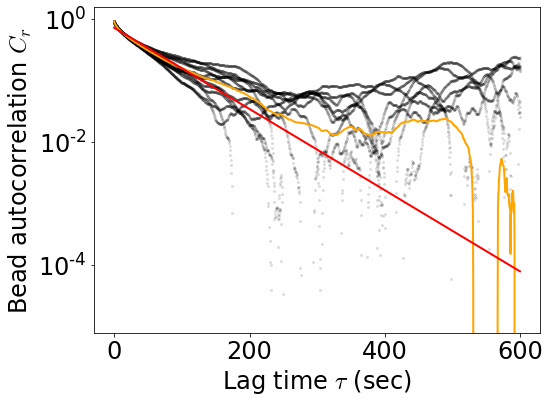

In [57]:
data_path = (ceph_path /"CondCharPaper/22-10-16_aLc1_line800_sticky55nm_kod.1-300/simulations/kod30")
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
ss_ind = 1200
end_ind = -1
start_bead = 0
end_bead = None

auto_corr_list = []
try:
    seed_paths = [path for path in data_path.glob('**/s*') if path.is_dir()]
    assert seed_paths
    
    for sp in seed_paths:
        with h5py.File(next(sp.glob('analysis/raw*.h5')), 'r+') as h5_data:
            lag_arr = h5_data['time'][:-ss_ind+end_ind]

            sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                                :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            com_arr -= com_arr.mean(axis=0)

            auto_corr_list += [poly_autocorr(com_arr)]
            _ = axarr.scatter(lag_arr, auto_corr_list[-1], color='k',alpha=.1)

    min_length = min([len(avg) for avg in auto_corr_list])
    auto_corr_list = torch.stack([avg[:min_length] for avg in auto_corr_list])
        
    _ = axarr.plot(lag_arr[1:min_length], auto_corr_list.mean(axis=0)[1:], color='orange')
    _ = axarr.set_xlabel(r'Lag time $\tau$ (sec)')
    _ = axarr.set_ylabel('Bead autocorrelation $C_r$')
    _ = axarr.set_yscale('log')
    params, cv = curve_fit(monoExp, lag_arr[1:min_length], auto_corr_list.mean(axis=0)[1:])
    _ = axarr.plot(lag_arr[1:min_length], monoExp(lag_arr[1:min_length], *params), color='r')
    print(params)
    # _ = axarr[1].plot(time_arr, np.array(avg_total_bead).mean(axis=0), color='orange')
    
    # _ = axarr[0].set_title('Number of clusters')
    # _ = axarr[1].set_title('Total beads in clusters')

    # _ = axarr[0].set_ylim(0)
    # _ = axarr[1].set_ylim(0)
        
except:
    raise

# Param-seed scan

## $K_e$ scans

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


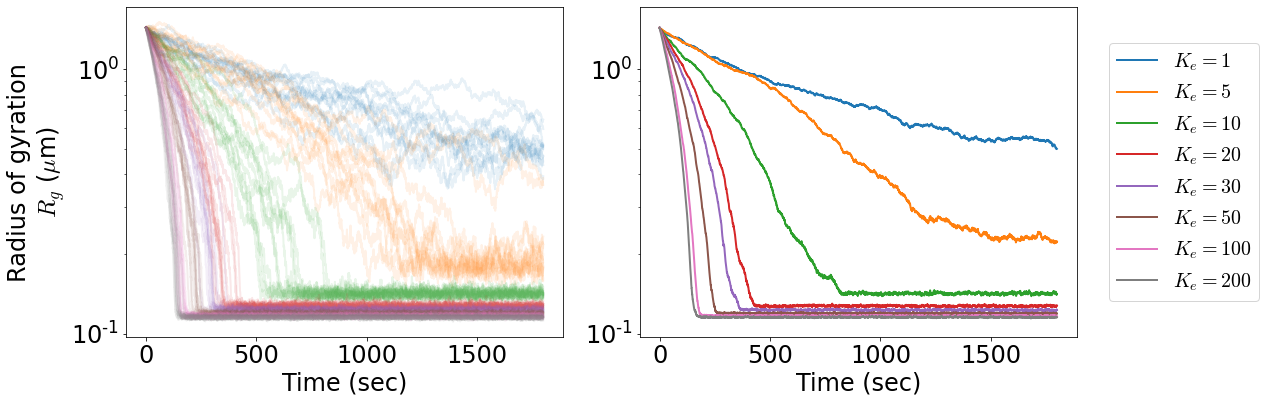

In [12]:
data_path = (ceph_path /"CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations")
colors = list(mcolors.TABLEAU_COLORS.keys())
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None
try:
    fig1, axarr1 = plt.subplots(1, 2, figsize=(18, 6))
    axarr1[0].sharey(axarr1[1])
    axarr1[0].sharex(axarr1[1])
    mp = re.compile('Ke(\d*\.?\d+)')

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    avg_ee_list = []
    std_ee_list = []
    for i, pd in enumerate(param_dirs):
        avg_ee_arrs = []
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue

        for h5_data in sd_h5_data_lst:
            time_arr = h5_data['time'][ss_ind:end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            n_beads = com_arr.shape[0]
            # ee_dist = aa.get_end_end_distance(com_arr)
            rog = aa.calc_rad_of_gyration(com_arr)
            _ = axarr1[0].plot(time_arr, rog, color=colors[i], alpha=.1)
            avg_ee_arrs += [rog.tolist()]
        min_length = min([len(avg) for avg in avg_ee_arrs])
        
        
        avg_ee_arrs = np.array([avg[:min_length] for avg in avg_ee_arrs])
        avg_ee_list += [avg_ee_arrs.mean(axis=0)]
        std_ee_list += [avg_ee_arrs.std(axis=0)]
        
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
    
        _ = axarr1[1].plot(time_arr[:min_length], avg_ee_list[-1], color=colors[i], label=f"$K_e = {label}$")
    
    _ = axarr1[0].set_ylabel('Radius of gyration\n' + r'$R_g$ ($\mu$m)')
    _ = axarr1[0].set_xlabel('Time (sec)')
    _ = axarr1[1].set_xlabel('Time (sec)')
    _ = axarr1[0].set_yscale('log')
    # _ = axarr1[0].set_ylim(0.1)

    _ = axarr1[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

0it [00:00, ?it/s]

[1.0, 5.0, 10.0, 20.0, 30.0, 50.0, 100.0, 200.0]


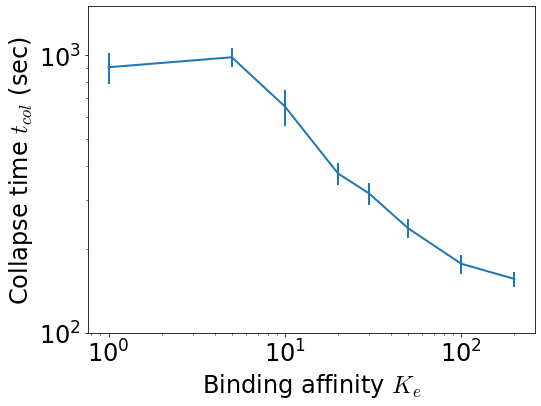

In [ ]:
data_path = (ceph_path /"CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations")
colors = list(mcolors.TABLEAU_COLORS.keys())
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None
try:
    fig1, axarr1 = plt.subplots(1, 1, figsize=(8, 6))
    mp = re.compile('Ke(\d*\.?\d+)')
    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    pvals = []
    collapse_times_avg = []
    collapse_times_std = []
    for i, pd in tqdm(enumerate(param_dirs)):
        pvals += [float(re.split(r'(^[^\d]+)',str(pd.name))[1:][1])]
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue
        clps_times = []
        for h5_data in sd_h5_data_lst:
            time_arr = h5_data['time'][ss_ind:end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            rog = aa.calc_rad_of_gyration(com_arr)
            clps_ind = find_steady_state_ind(rog, [-600, None])
            clps_times += [time_arr[clps_ind]]
        collapse_times_avg += [np.mean(clps_times)]
        collapse_times_std += [np.std(clps_times)]
    print(pvals)

    _ = axarr1.errorbar(pvals, collapse_times_avg, yerr=collapse_times_std )
        
    _ = axarr1.set_ylabel('Collapse time' + r" $t_{col}$ (sec)")
    _ = axarr1.set_xlabel('Binding affinity $K_e$')
    _ = axarr1.set_yscale('log')
    _ = axarr1.set_xscale('log')
    _ = axarr1.set_ylim(100, 1500)

    # _ = axarr1[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
    # fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

0it [00:00, ?it/s]

[1.0, 5.0, 10.0, 20.0, 30.0, 50.0, 100.0, 200.0]


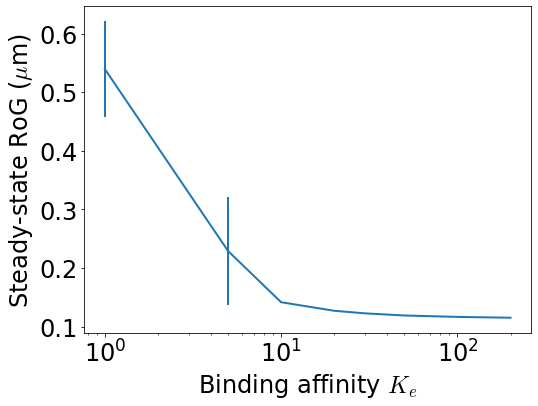

In [50]:
data_path = (ceph_path /"CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations")
colors = list(mcolors.TABLEAU_COLORS.keys())
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None
try:
    fig1, axarr1 = plt.subplots(1, 1, figsize=(8, 6))
    mp = re.compile('Ke(\d*\.?\d+)')
    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    pvals = []
    rog_avg = []
    rog_std = []
    for i, pd in tqdm(enumerate(param_dirs)):
        pvals += [float(re.split(r'(^[^\d]+)',str(pd.name))[1:][1])]
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue
        rog_arr = []
        for h5_data in sd_h5_data_lst:
            time_arr = h5_data['time'][ss_ind:end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            rog_arr += [aa.calc_rad_of_gyration(com_arr[:,:,-600:]).mean()]
        rog_avg += [np.mean(rog_arr)]
        rog_std += [np.std(rog_arr)]
    print(pvals)

    _ = axarr1.errorbar(pvals[:], rog_avg[:], yerr=rog_std[:] )
        
    _ = axarr1.set_ylabel('Steady-state RoG ($\mu$m)')
    _ = axarr1.set_xlabel('Binding affinity $K_e$')
    # _ = axarr1.set_yscale('log')
    _ = axarr1.set_xscale('log')
    # _ = axarr1.set_ylim(100, 1500)

    # _ = axarr1[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
    # fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

0it [00:00, ?it/s]

[1.0, 5.0, 10.0, 20.0, 30.0, 50.0, 100.0, 200.0]


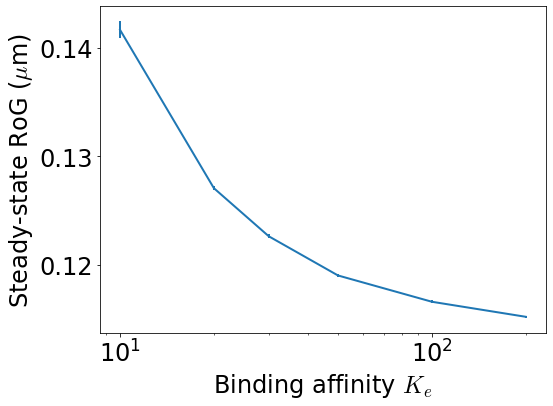

In [ ]:
data_path = (ceph_path /"CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations")
colors = list(mcolors.TABLEAU_COLORS.keys())
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None
try:
    fig1, axarr1 = plt.subplots(1, 1, figsize=(8, 6))
    mp = re.compile('Ke(\d*\.?\d+)')
    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    pvals = []
    rog_avg = []
    rog_std = []
    for i, pd in tqdm(enumerate(param_dirs)):
        pvals += [float(re.split(r'(^[^\d]+)',str(pd.name))[1:][1])]
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue
        rog_arr = []
        for h5_data in sd_h5_data_lst:
            time_arr = h5_data['time'][ss_ind:end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            rog_arr += [aa.calc_rad_of_gyration(com_arr[:,:,-600:]).mean()]
        rog_avg += [np.mean(rog_arr)]
        rog_std += [np.std(rog_arr)]
    print(pvals)

    _ = axarr1.errorbar(pvals[2:], rog_avg[2:], yerr=rog_std[2:] )
        
    _ = axarr1.set_ylabel('Steady-state RoG ($\mu$m)')
    _ = axarr1.set_xlabel('Binding affinity $K_e$')
    # _ = axarr1.set_yscale('log')
    _ = axarr1.set_xscale('log')
    # _ = axarr1.set_ylim(100, 1500)

    # _ = axarr1[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
    # fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

0it [00:00, ?it/s]

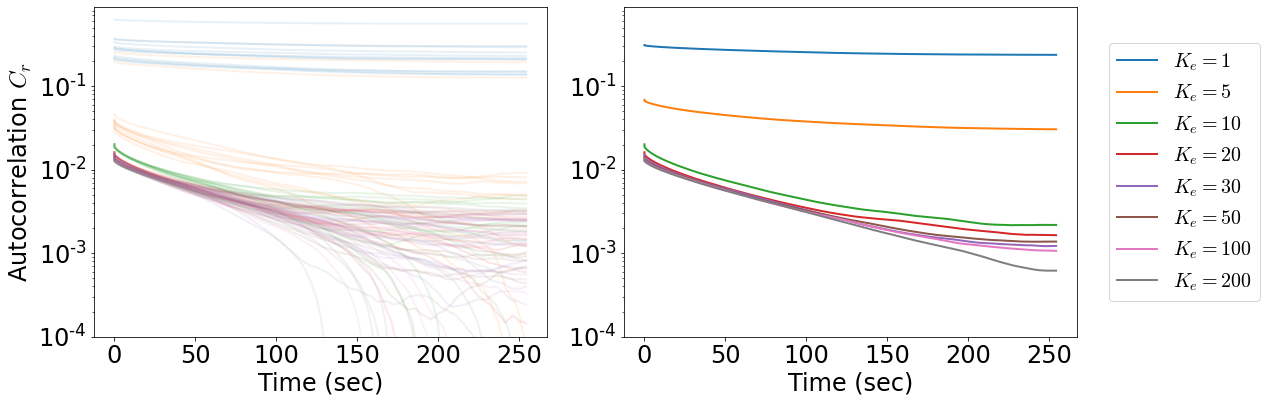

In [49]:
data_path = (ceph_path /"CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations")
colors = list(mcolors.TABLEAU_COLORS.keys())
ss_ind = -1023
end_ind = -1
start_bead = 0
end_bead = None
try:
    fig1, axarr1 = plt.subplots(1, 2, figsize=(18, 6))
    axarr1[0].sharey(axarr1[1])
    axarr1[0].sharex(axarr1[1])
    mp = re.compile('Ke(\d*\.?\d+)')

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    avg_auto_corr_list = []
    std_auto_corr_list = []
    for i, pd in tqdm(enumerate(param_dirs)):
        auto_corr_list = []
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue

        for h5_data in sd_h5_data_lst:
            valid_n = int((-ss_ind+end_ind)/2)
            lag_arr = h5_data['time'][:valid_n]
            # time_arr = h5_data['time'][:-ss_ind+end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            n_beads = com_arr.shape[0]
            auto_corr_list += [poly_autocorr_fast(com_arr)[:valid_n]]
            _ = axarr1[0].plot(lag_arr, auto_corr_list[-1].cpu(), color=colors[i], alpha=.1)
        min_length = min([len(avg) for avg in auto_corr_list])
        auto_corr_mat = torch.stack([avg[:min_length] for avg in auto_corr_list])
        
        avg_auto_corr_list += [auto_corr_mat.mean(dim=0)]
        std_auto_corr_list += [auto_corr_mat.std(dim=0)]
        
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
    
        _ = axarr1[1].plot(lag_arr[:min_length], avg_auto_corr_list[-1].cpu(), color=colors[i],label=f"$K_e = {label}$")
    
    _ = axarr1[0].set_ylabel('Autocorrelation ' + r'$C_r$')
    _ = axarr1[0].set_xlabel('Time (sec)')
    _ = axarr1[1].set_xlabel('Time (sec)')
    # _ = axarr1[0].set_xscale('log')
    _ = axarr1[0].set_yscale('log')
    _ = axarr1[0].set_ylim(0.0001)

    _ = axarr1[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

0it [00:00, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 5.72 GiB (GPU 0; 23.62 GiB total capacity; 17.20 GiB already allocated; 5.37 GiB free; 17.20 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

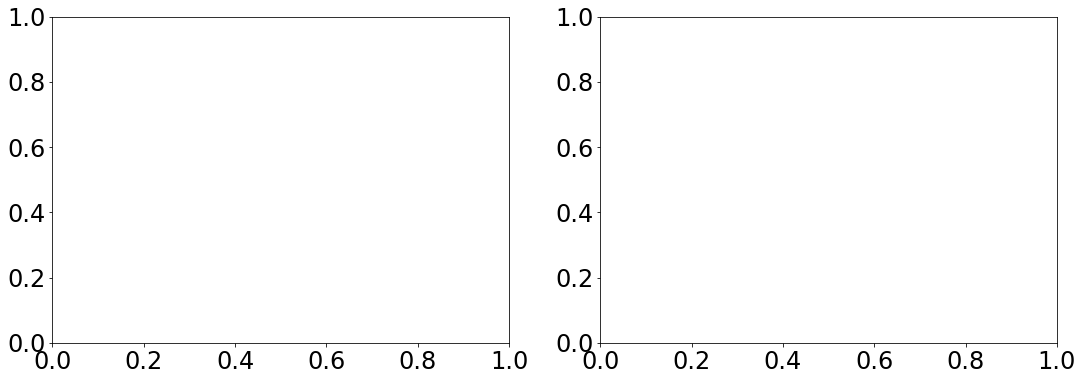

In [14]:
data_path = (ceph_path /"CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations")
colors = list(mcolors.TABLEAU_COLORS.keys())
ss_ind = 1200
end_ind = -1
start_bead = 0
end_bead = None
try:
    fig1, axarr1 = plt.subplots(1, 2, figsize=(18, 6))
    axarr1[0].sharey(axarr1[1])
    axarr1[0].sharex(axarr1[1])
    mp = re.compile('Ke(\d*\.?\d+)')

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    avg_auto_corr_list = []
    std_auto_corr_list = []
    for i, pd in tqdm(enumerate(param_dirs)):
        auto_corr_list = []
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue

        for h5_data in tqdm(sd_h5_data_lst):

            time_arr = h5_data['time'][:-ss_ind+end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            n_beads = com_arr.shape[0]
            auto_corr_list += [sep_autocorr(com_arr)]
            _ = axarr1[0].plot(time_arr, auto_corr_list[-1].cpu(), color=colors[i], alpha=.1)
        min_length = min([len(avg) for avg in auto_corr_list])
        auto_corr_mat = torch.stack([avg[:min_length] for avg in auto_corr_list])
        
        avg_auto_corr_list += [auto_corr_mat.mean(axis=0)]
        std_auto_corr_list += [auto_corr_mat.std(axis=0)]
        
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
    
        _ = axarr1[1].plot(time_arr[:min_length], avg_auto_corr_list[-1].cpu(), color=colors[i], label=f"$ K_e = {label}$")
    
    _ = axarr1[0].set_ylabel('Autocorrelation' + r' $C_r$')
    _ = axarr1[0].set_xlabel('Time (sec)')
    _ = axarr1[1].set_xlabel('Time (sec)')
    # _ = axarr1[0].set_yscale('log')
    # _ = axarr1[0].set_ylim(0.1)

    _ = axarr1[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

In [ ]:
data_path = (ceph_path /"CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations")
colors = list(mcolors.TABLEAU_COLORS.keys())
ss_ind = 1200
end_ind = -1
start_bead = 0
end_bead = None
try:
    fig1, axarr1 = plt.subplots(1, 2, figsize=(18, 6))
    axarr1[0].sharey(axarr1[1])
    axarr1[0].sharex(axarr1[1])
    mp = re.compile('Ke(\d*\.?\d+)')

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    avg_auto_corr_list = []
    std_auto_corr_list = []
    for i, pd in tqdm(enumerate(param_dirs)):
        auto_corr_list = []
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue

        for h5_data in tqdm(sd_h5_data_lst):
            t0 = time.time()
            time_arr = h5_data['time'][:-ss_ind+end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            t1 = time.time()
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            print(f'com load time = {t1-t0}')
            n_beads = com_arr.shape[0]
            auto_corr_list += [autocorr_fast(com_arr)]
            t2 = time.time()
            print(f'autocorr time = {t2-t1}')
            _ = axarr1[0].plot(time_arr, auto_corr_list[-1].cpu(), color=colors[i], alpha=.1)
        min_length = min([len(avg) for avg in auto_corr_list])
        auto_corr_mat = torch.stack([avg[:min_length] for avg in auto_corr_list])
        
        avg_auto_corr_list += [auto_corr_mat.mean(axis=0)]
        std_auto_corr_list += [auto_corr_mat.std(axis=0)]
        
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
    
        _ = axarr1[1].plot(time_arr[:min_length], avg_auto_corr_list[-1].cpu(), color=colors[i], label=f"$ K_e = {label}$")
    
    _ = axarr1[0].set_ylabel('Autocorrelation' + r' $C_r$')
    _ = axarr1[0].set_xlabel('Time (sec)')
    _ = axarr1[1].set_xlabel('Time (sec)')
    # _ = axarr1[0].set_yscale('log')
    # _ = axarr1[0].set_ylim(0.1)

    _ = axarr1[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

0it [00:00, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

com load time = 0.02950906753540039


0it [00:00, ?it/s]

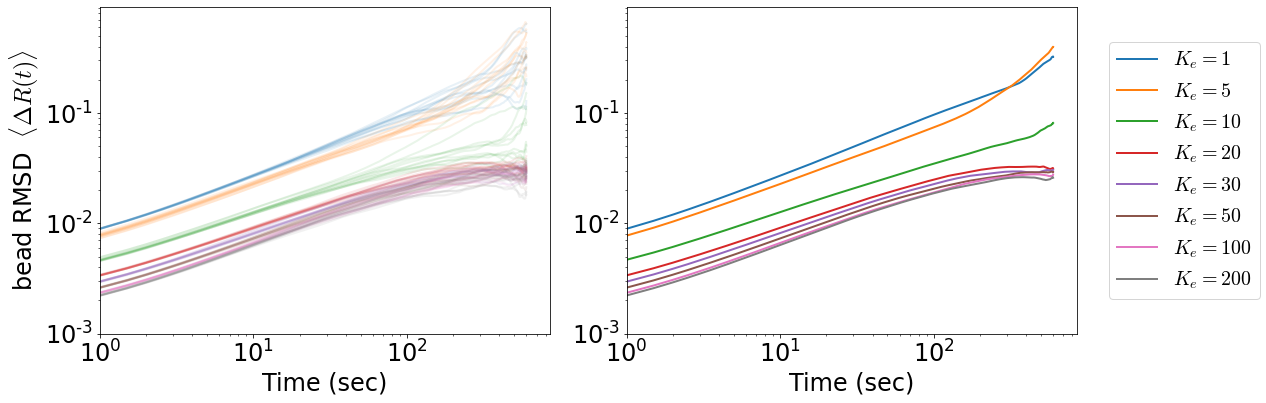

In [12]:
data_path = (ceph_path /"CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations")
colors = list(mcolors.TABLEAU_COLORS.keys())
ss_ind = 1200
end_ind = -1
start_bead = 0
end_bead = None
try:
    fig1, axarr1 = plt.subplots(1, 2, figsize=(18, 6))
    axarr1[0].sharey(axarr1[1])
    axarr1[0].sharex(axarr1[1])
    mp = re.compile('Ke(\d*\.?\d+)')

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    avg_auto_corr_list = []
    std_auto_corr_list = []
    for i, pd in tqdm(enumerate(param_dirs)):
        auto_corr_list = []
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue

        for h5_data in sd_h5_data_lst:

            time_arr = h5_data['time'][:-ss_ind+end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            n_beads = com_arr.shape[0]
            auto_corr_list += [poly_bead_rmsd(com_arr)]
            _ = axarr1[0].plot(time_arr, auto_corr_list[-1].cpu(), color=colors[i], alpha=.1)
        min_length = min([len(avg) for avg in auto_corr_list])
        auto_corr_mat = torch.stack([avg[:min_length] for avg in auto_corr_list])
        
        avg_auto_corr_list += [auto_corr_mat.mean(axis=0)]
        std_auto_corr_list += [auto_corr_mat.std(axis=0)]
        
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
    
        _ = axarr1[1].plot(time_arr[:min_length], avg_auto_corr_list[-1].cpu(), color=colors[i], label=f"$ K_e = {label}$")
    
    _ = axarr1[0].set_ylabel('bead RMSD ' + r' $\langle \Delta R(t)\rangle$')
    _ = axarr1[0].set_xlabel('Time (sec)')
    _ = axarr1[1].set_xlabel('Time (sec)')
    _ = axarr1[0].set_yscale('log')
    _ = axarr1[0].set_xscale('log')
    _ = axarr1[0].set_ylim(0.001)
    _ = axarr1[0].set_xlim(1.0)

    _ = axarr1[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

## $k_o$ scans

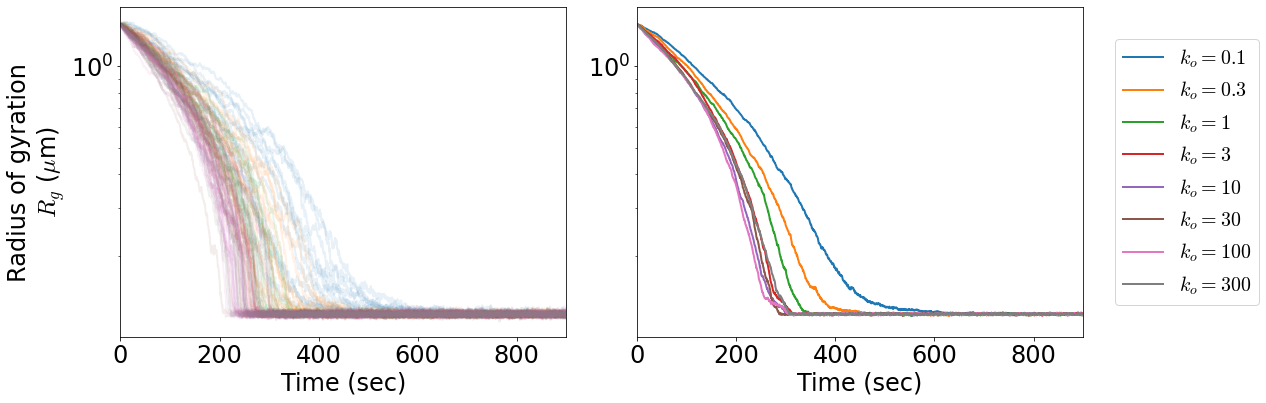

In [12]:
data_path = (ceph_path /"CondCharPaper/22-10-16_aLc1_line800_sticky55nm_kod.1-300/simulations")
colors = list(mcolors.TABLEAU_COLORS.keys())
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None
try:
    fig1, axarr1 = plt.subplots(1, 2, figsize=(18, 6))
    axarr1[0].sharey(axarr1[1])
    axarr1[0].sharex(axarr1[1])
    mp = re.compile('kod(\d*\.?\d+)')

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    avg_ee_list = []
    std_ee_list = []
    for i, pd in enumerate(param_dirs):
        avg_ee_arrs = []
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue

        for h5_data in sd_h5_data_lst:
            time_arr = h5_data['time'][ss_ind:end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            n_beads = com_arr.shape[0]
            # ee_dist = aa.get_end_end_distance(com_arr)
            rog = aa.calc_rad_of_gyration(com_arr)
            _ = axarr1[0].plot(time_arr, rog, color=colors[i], alpha=.1)
            avg_ee_arrs += [rog.tolist()]
        min_length = min([len(avg) for avg in avg_ee_arrs])
        
        
        avg_ee_arrs = np.array([avg[:min_length] for avg in avg_ee_arrs])
        avg_ee_list += [avg_ee_arrs.mean(axis=0)]
        std_ee_list += [avg_ee_arrs.std(axis=0)]
        
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
    
        _ = axarr1[1].plot(time_arr[:min_length], avg_ee_list[-1], color=colors[i], label=f"$k_o = {label}$")
    
    _ = axarr1[0].set_ylabel('Radius of gyration\n' + r'$R_g$ ($\mu$m)')
    _ = axarr1[0].set_xlabel('Time (sec)')
    _ = axarr1[1].set_xlabel('Time (sec)')
    _ = axarr1[0].set_yscale('log')
    # _ = axarr1[0].set_ylim(0.1)
    _ = axarr1[0].set_xlim(0, 900)

    _ = axarr1[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

0it [00:00, ?it/s]

[1.0, 5.0, 10.0, 20.0, 30.0, 50.0, 100.0, 200.0]


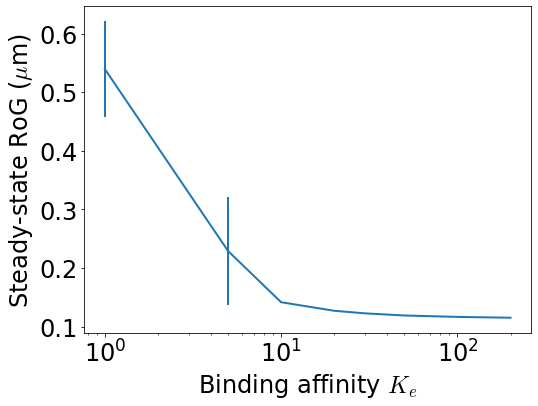

In [ ]:
data_path = (ceph_path /"CondCharPaper/22-10-16_aLc1_line800_sticky55nm_kod.1-300/simulations")
colors = list(mcolors.TABLEAU_COLORS.keys())
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None
try:
    fig1, axarr1 = plt.subplots(1, 1, figsize=(8, 6))
    mp = re.compile('kod(\d*\.?\d+)')
    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    pvals = []
    rog_avg = []
    rog_std = []
    for i, pd in tqdm(enumerate(param_dirs)):
        pvals += [float(re.split(r'(^[^\d]+)',str(pd.name))[1:][1])]
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue
        rog_arr = []
        for h5_data in sd_h5_data_lst:
            time_arr = h5_data['time'][ss_ind:end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            rog_arr += [aa.calc_rad_of_gyration(com_arr[:,:,-600:]).mean()]
        rog_avg += [np.mean(rog_arr)]
        rog_std += [np.std(rog_arr)]
    print(pvals)

    _ = axarr1.errorbar(pvals[:], rog_avg[:], yerr=rog_std[:] )
        
    _ = axarr1.set_ylabel('Steady-state RoG ($\mu$m)')
    _ = axarr1.set_xlabel('Turnover rate $k_o$ (sec$^{-1}$)')

    # _ = axarr1.set_yscale('log')
    _ = axarr1.set_xscale('log')
    # _ = axarr1.set_ylim(100, 1500)

    # _ = axarr1[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
    # fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

0it [00:00, ?it/s]

[0.1, 0.3, 1.0, 3.0, 10.0, 30.0, 100.0, 300.0]


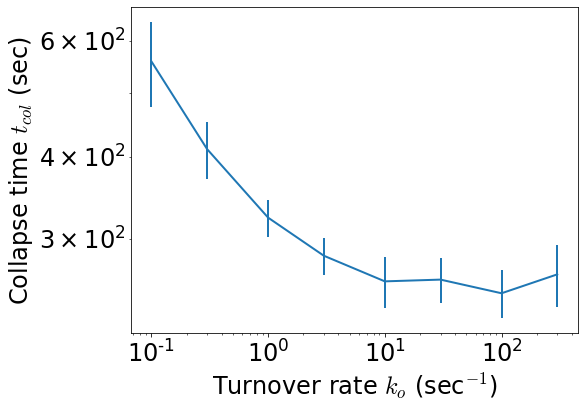

In [14]:
data_path = (ceph_path /"CondCharPaper/22-10-16_aLc1_line800_sticky55nm_kod.1-300/simulations")
colors = list(mcolors.TABLEAU_COLORS.keys())
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None
try:
    fig1, axarr1 = plt.subplots(1, 1, figsize=(8, 6))
    pvals = []
    mp = re.compile('kod(\d*\.?\d+)')
    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    collapse_times_avg = []
    collapse_times_std = []
    for i, pd in tqdm(enumerate(param_dirs)):
        pvals += [float(re.split(r'(^[^\d]+)',str(pd.name))[1:][1])]
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue
        clps_times = []
        for h5_data in sd_h5_data_lst:
            time_arr = h5_data['time'][ss_ind:end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            rog = aa.calc_rad_of_gyration(com_arr)
            clps_ind = find_steady_state_ind(rog, [-600, None])
            clps_times += [time_arr[clps_ind]]
        collapse_times_avg += [np.mean(clps_times)]
        collapse_times_std += [np.std(clps_times)]

    print(pvals)
    _ = axarr1.errorbar(pvals, collapse_times_avg, yerr=collapse_times_std )
        
    _ = axarr1.set_ylabel('Collapse time' + r" $t_{col}$ (sec)")
    _ = axarr1.set_xlabel('Turnover rate $k_o$ (sec$^{-1}$)')
    _ = axarr1.set_yscale('log')
    _ = axarr1.set_xscale('log')
    # _ = axarr1.set_ylim(20, 200)

    # _ = axarr1[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
    # fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

0it [00:00, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


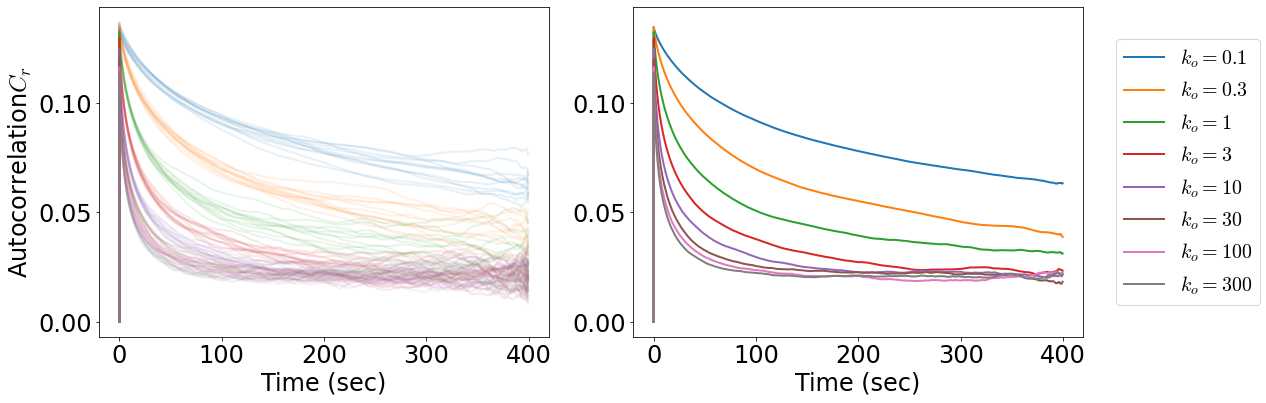

In [7]:
data_path = (ceph_path /"CondCharPaper/22-10-16_aLc1_line800_sticky55nm_kod.1-300/simulations")
colors = list(mcolors.TABLEAU_COLORS.keys())
ss_ind = 1600
end_ind = -1
start_bead = 0
end_bead = None
try:
    fig1, axarr1 = plt.subplots(1, 2, figsize=(18, 6))
    axarr1[0].sharey(axarr1[1])
    axarr1[0].sharex(axarr1[1])
    mp = re.compile('kod(\d*\.?\d+)')

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    avg_auto_corr_list = []
    std_auto_corr_list = []
    for i, pd in tqdm(enumerate(param_dirs)):
        auto_corr_list = []
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue

        for h5_data in tqdm(sd_h5_data_lst):

            time_arr = h5_data['time'][:-ss_ind+end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            n_beads = com_arr.shape[0]
            auto_corr_list += [sep_autocorr(com_arr)]
            _ = axarr1[0].plot(time_arr, auto_corr_list[-1].cpu(), color=colors[i], alpha=.1)
        min_length = min([len(avg) for avg in auto_corr_list])
        auto_corr_mat = torch.stack([avg[:min_length] for avg in auto_corr_list])
        
        avg_auto_corr_list += [auto_corr_mat.mean(axis=0)]
        std_auto_corr_list += [auto_corr_mat.std(axis=0)]
        
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
    
        _ = axarr1[1].plot(time_arr[:min_length], avg_auto_corr_list[-1].cpu(), color=colors[i], label=f"$ k_o = {label}$")
    
    _ = axarr1[0].set_ylabel('Autocorrelation' + r'$C_r$')
    _ = axarr1[0].set_xlabel('Time (sec)')
    _ = axarr1[1].set_xlabel('Time (sec)')
    # _ = axarr1[0].set_yscale('log')
    # _ = axarr1[0].set_ylim(0.1)

    _ = axarr1[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

0it [00:00, ?it/s]

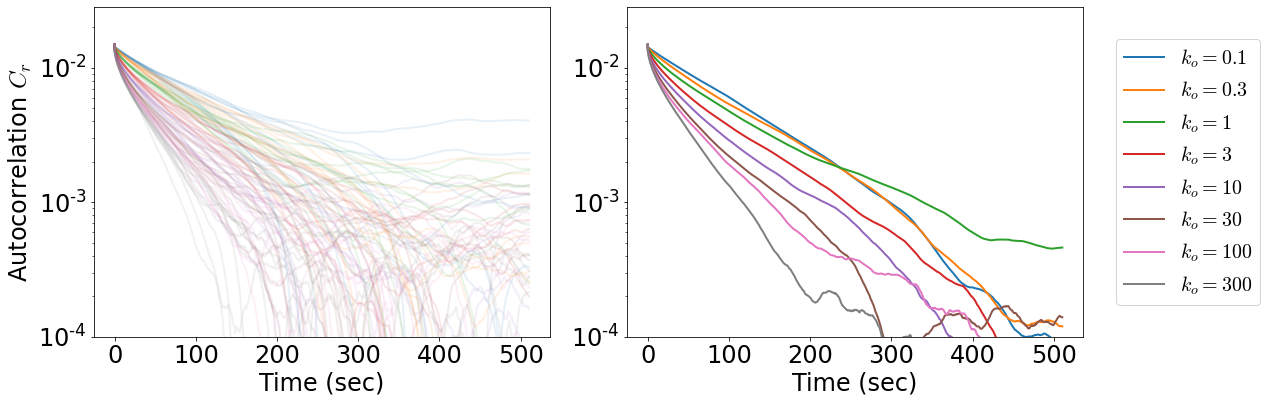

In [26]:
data_path = (ceph_path /"CondCharPaper/22-10-16_aLc1_line800_sticky55nm_kod.1-300/simulations")
colors = list(mcolors.TABLEAU_COLORS.keys())
ss_ind = -2047
end_ind = -1
start_bead = 0
end_bead = None
try:
    fig1, axarr1 = plt.subplots(1, 2, figsize=(18, 6))
    axarr1[0].sharey(axarr1[1])
    axarr1[0].sharex(axarr1[1])
    mp = re.compile('kod(\d*\.?\d+)')

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    avg_auto_corr_list = []
    std_auto_corr_list = []
    for i, pd in tqdm(enumerate(param_dirs)):
        auto_corr_list = []
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue

        for h5_data in sd_h5_data_lst:
            valid_n = int((-ss_ind+end_ind)/2)
            lag_arr = h5_data['time'][:valid_n]
            # time_arr = h5_data['time'][:-ss_ind+end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            n_beads = com_arr.shape[0]
            auto_corr_list += [poly_autocorr_fast(com_arr)[:valid_n]]
            _ = axarr1[0].plot(lag_arr, auto_corr_list[-1].cpu(), color=colors[i], alpha=.1)
        min_length = min([len(avg) for avg in auto_corr_list])
        auto_corr_mat = torch.stack([avg[:min_length] for avg in auto_corr_list])
        
        avg_auto_corr_list += [auto_corr_mat.mean(dim=0)]
        std_auto_corr_list += [auto_corr_mat.std(dim=0)]
        
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
    
        _ = axarr1[1].plot(lag_arr[:min_length], avg_auto_corr_list[-1].cpu(), color=colors[i], label=f"$ k_o = {label}$")
    
    _ = axarr1[0].set_ylabel('Autocorrelation ' + r'$C_r$')
    _ = axarr1[0].set_xlabel('Time (sec)')
    _ = axarr1[1].set_xlabel('Time (sec)')
    # _ = axarr1[0].set_xscale('log')
    _ = axarr1[0].set_yscale('log')
    _ = axarr1[0].set_ylim(0.0001)

    _ = axarr1[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

0it [00:00, ?it/s]

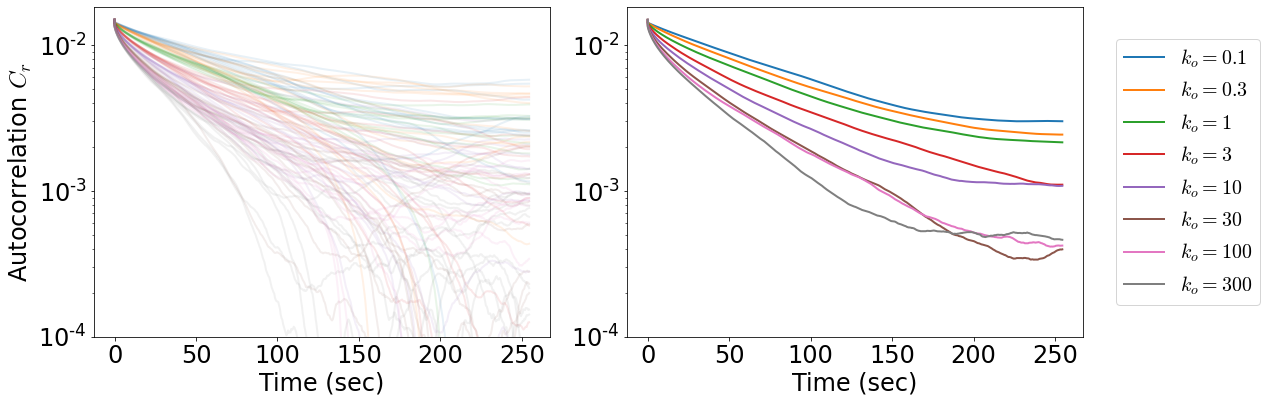

In [35]:
data_path = (ceph_path /"CondCharPaper/22-10-16_aLc1_line800_sticky55nm_kod.1-300/simulations")
colors = list(mcolors.TABLEAU_COLORS.keys())
ss_ind = -1023
end_ind = -1
start_bead = 0
end_bead = None
try:
    fig1, axarr1 = plt.subplots(1, 2, figsize=(18, 6))
    axarr1[0].sharey(axarr1[1])
    axarr1[0].sharex(axarr1[1])
    mp = re.compile('kod(\d*\.?\d+)')

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    avg_auto_corr_list = []
    std_auto_corr_list = []
    for i, pd in tqdm(enumerate(param_dirs)):
        auto_corr_list = []
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue

        for h5_data in sd_h5_data_lst:
            valid_n = int((-ss_ind+end_ind)/2)
            lag_arr = h5_data['time'][:valid_n]
            # time_arr = h5_data['time'][:-ss_ind+end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            n_beads = com_arr.shape[0]
            auto_corr_list += [poly_autocorr_fast(com_arr)[:valid_n]]
            _ = axarr1[0].plot(lag_arr, auto_corr_list[-1].cpu(), color=colors[i], alpha=.1)
        min_length = min([len(avg) for avg in auto_corr_list])
        auto_corr_mat = torch.stack([avg[:min_length] for avg in auto_corr_list])
        
        avg_auto_corr_list += [auto_corr_mat.mean(dim=0)]
        std_auto_corr_list += [auto_corr_mat.std(dim=0)]
        
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
    
        _ = axarr1[1].plot(lag_arr[:min_length], avg_auto_corr_list[-1].cpu(), color=colors[i], label=f"$ k_o = {label}$")
    
    _ = axarr1[0].set_ylabel('Autocorrelation ' + r'$C_r$')
    _ = axarr1[0].set_xlabel('Time (sec)')
    _ = axarr1[1].set_xlabel('Time (sec)')
    # _ = axarr1[0].set_xscale('log')
    _ = axarr1[0].set_yscale('log')
    _ = axarr1[0].set_ylim(0.0001)

    _ = axarr1[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

0it [00:00, ?it/s]

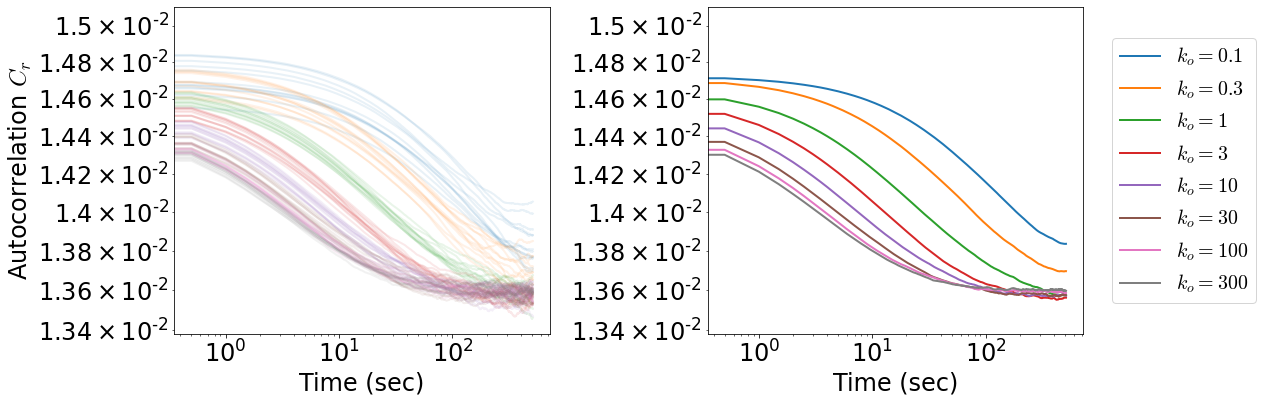

In [71]:
data_path = (ceph_path /"CondCharPaper/22-10-16_aLc1_line800_sticky55nm_kod.1-300/simulations")
colors = list(mcolors.TABLEAU_COLORS.keys())
ss_ind = -2047
end_ind = -1
start_bead = 0
end_bead = None
try:
    fig1, axarr1 = plt.subplots(1, 2, figsize=(18, 6))
    axarr1[0].sharey(axarr1[1])
    axarr1[0].sharex(axarr1[1])
    mp = re.compile('kod(\d*\.?\d+)')

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    avg_auto_corr_list = []
    std_auto_corr_list = []
    for i, pd in tqdm(enumerate(param_dirs)):
        auto_corr_list = []
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue

        for h5_data in sd_h5_data_lst:
            valid_n = int((-ss_ind+end_ind)/2)
            lag_arr = h5_data['time'][:valid_n]
            # time_arr = h5_data['time'][:-ss_ind+end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            n_beads = com_arr.shape[0]
            auto_corr_list += [poly_dist_autocorr_fast(com_arr)[:valid_n]]
            _ = axarr1[0].plot(lag_arr, auto_corr_list[-1].cpu(), color=colors[i], alpha=.1)
        min_length = min([len(avg) for avg in auto_corr_list])
        auto_corr_mat = torch.stack([avg[:min_length] for avg in auto_corr_list])
        
        avg_auto_corr_list += [auto_corr_mat.mean(dim=0)]
        std_auto_corr_list += [auto_corr_mat.std(dim=0)]
        
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
    
        _ = axarr1[1].plot(lag_arr[:min_length], avg_auto_corr_list[-1].cpu(), color=colors[i], label=f"$ k_o = {label}$")
    
    _ = axarr1[0].set_ylabel('Autocorrelation ' + r'$C_r$')
    _ = axarr1[0].set_xlabel('Time (sec)')
    _ = axarr1[1].set_xlabel('Time (sec)')
    _ = axarr1[0].set_xscale('log')
    _ = axarr1[0].set_yscale('log')
    # _ = axarr1[0].set_ylim(0.0001)

    _ = axarr1[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

0it [00:00, ?it/s]

[0.1, 0.3, 1.0, 3.0, 10.0, 30.0, 100.0, 300.0]
[129.5286415553931, 118.23093859916258, 109.43642926430033, 85.13155312678491, 70.70200384843385, 52.510375950678515, 52.476610213350575, 42.843708383470315]
[-6.94921158e+01  1.69872530e+02 -7.70176078e-02]


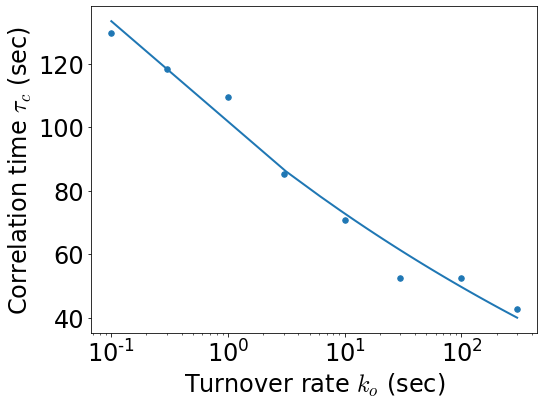

In [32]:
data_path = (ceph_path /"CondCharPaper/22-10-16_aLc1_line800_sticky55nm_kod.1-300/simulations")
colors = list(mcolors.TABLEAU_COLORS.keys())
ss_ind = -1024
end_ind = -1
start_bead = 0
end_bead = None
try:
    fig1, axarr1 = plt.subplots(1, 1, figsize=(8, 6))
    pvals = []
    exp_vals = []
    for i, pd in tqdm(enumerate(param_dirs)):
        pvals += [float(re.split(r'(^[^\d]+)',str(pd.name))[1:][1])]
        # Find exponential values with a fit
        params, cv = curve_fit(monoExp, lag_arr[:min_length], avg_auto_corr_list[i].to('cpu'))
        exp_vals += [1./params[-1]]
    
    print(pvals)
    print(exp_vals)
    _ = axarr1.scatter(pvals, exp_vals, s=30)
    pow_params, cv = curve_fit(func_powerlaw, pvals[:], exp_vals[:], p0=(0, 100, -0.1))
    print(pow_params)
    x = np.linspace(pvals[0], pvals[-1], 100)
    y = func_powerlaw(x, *pow_params)
    _ = axarr1.plot(x, y)

    _ = axarr1.set_ylabel('Correlation time ' + r'$\tau_c$ (sec)')
    _ = axarr1.set_xlabel('Turnover rate $k_o$ (sec)')
    # _ = axarr1.set_yscale('log')
    _ = axarr1.set_xscale('log')
    # _ = axarr1.set_ylim(20, 200)

    # _ = axarr1[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
    # fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

0it [00:00, ?it/s]

[0.1, 0.3, 1.0, 3.0, 10.0, 30.0, 100.0, 300.0]
[129.5286415553931, 118.23093859916258, 109.43642926430033, 85.13155312678491, 70.70200384843385, 52.510375950678515, 52.476610213350575, 42.843708383470315]
[ 1.         98.25601207 -0.14079804]


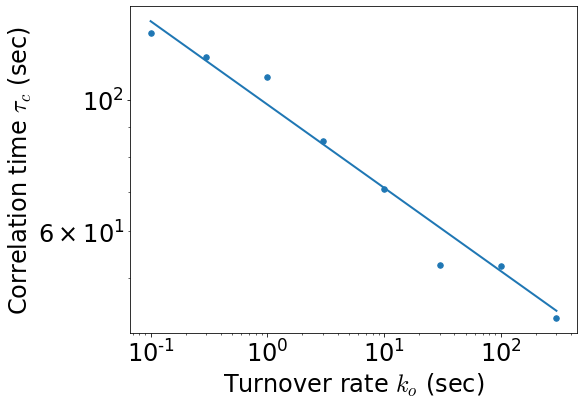

In [36]:
# torch.cuda.empty_cache()
# gc.collect()
data_path = (ceph_path /"CondCharPaper/22-10-16_aLc1_line800_sticky55nm_kod.1-300/simulations")
colors = list(mcolors.TABLEAU_COLORS.keys())
ss_ind = -1024
end_ind = -1
start_bead = 0
end_bead = None
try:
    fig1, axarr1 = plt.subplots(1, 1, figsize=(8, 6))
    pvals = []
    exp_vals = []
    for i, pd in tqdm(enumerate(param_dirs)):
        pvals += [float(re.split(r'(^[^\d]+)',str(pd.name))[1:][1])]
        # Find exponential values with a fit
        params, cv = curve_fit(monoExp, lag_arr[:min_length], avg_auto_corr_list[i].to('cpu'))
        exp_vals += [1./params[-1]]
    
    print(pvals)
    print(exp_vals)
    # _ = axarr1.errorbar(pvals, collapse_times_avg, yerr=collapse_times_std,  )
    _ = axarr1.scatter(pvals, exp_vals, s=30)
    pow_params, cv = curve_fit(func_powerlaw_zero, pvals[:], exp_vals[:])
    print(pow_params)
    x = np.linspace(pvals[0], pvals[-1], 100)
    y = func_powerlaw_zero(x, *pow_params)
    _ = axarr1.plot(x, y)

    _ = axarr1.set_ylabel('Correlation time ' + r'$\tau_c$ (sec)')
    _ = axarr1.set_xlabel('Turnover rate $k_o$ (sec)')
    _ = axarr1.set_yscale('log')
    _ = axarr1.set_xscale('log')
    # _ = axarr1.set_ylim(20, 200)

    # _ = axarr1[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
    # fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

0it [00:00, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

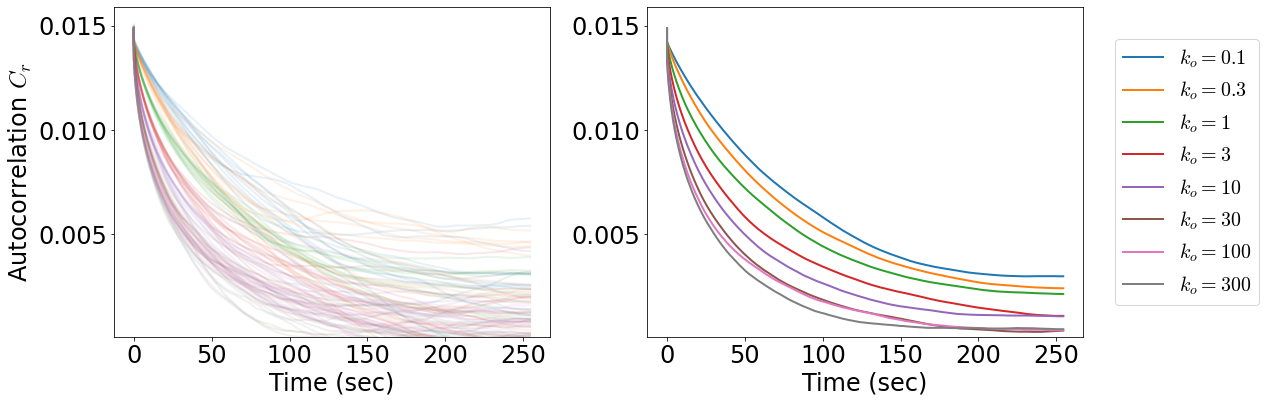

In [63]:
data_path = (ceph_path /"CondCharPaper/22-10-16_aLc1_line800_sticky55nm_kod.1-300/simulations")
colors = list(mcolors.TABLEAU_COLORS.keys())
ss_ind = -1024
end_ind = -1
start_bead = 0
end_bead = None
try:
    fig1, axarr1 = plt.subplots(1, 2, figsize=(18, 6))
    axarr1[0].sharey(axarr1[1])
    axarr1[0].sharex(axarr1[1])
    mp = re.compile('kod(\d*\.?\d+)')

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    avg_auto_corr_list = []
    std_auto_corr_list = []
    for i, pd in tqdm(enumerate(param_dirs)):
        auto_corr_list = []
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue

        for h5_data in tqdm(sd_h5_data_lst):
            valid_n = int((-ss_ind+end_ind)/2)
            lag_arr = h5_data['time'][:valid_n]
            # time_arr = h5_data['time'][:-ss_ind+end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            n_beads = com_arr.shape[0]
            auto_corr_list += [poly_autocorr_fast(com_arr)[:valid_n]]
            _ = axarr1[0].plot(lag_arr, auto_corr_list[-1].cpu(), color=colors[i], alpha=.1)
        min_length = min([len(avg) for avg in auto_corr_list])
        auto_corr_mat = torch.stack([avg[:min_length] for avg in auto_corr_list])
        
        avg_auto_corr_list += [auto_corr_mat.mean(dim=0)]
        std_auto_corr_list += [auto_corr_mat.std(dim=0)]
        
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
    
        _ = axarr1[1].plot(lag_arr[:min_length], avg_auto_corr_list[-1].cpu(), color=colors[i], label=f"$ k_o = {label}$")
    
    _ = axarr1[0].set_ylabel('Autocorrelation ' + r'$C_r$')
    _ = axarr1[0].set_xlabel('Time (sec)')
    _ = axarr1[1].set_xlabel('Time (sec)')
    # _ = axarr1[0].set_xscale('log')
    # _ = axarr1[0].set_yscale('log')
    _ = axarr1[0].set_ylim(0.0001)

    _ = axarr1[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

0it [00:00, ?it/s]

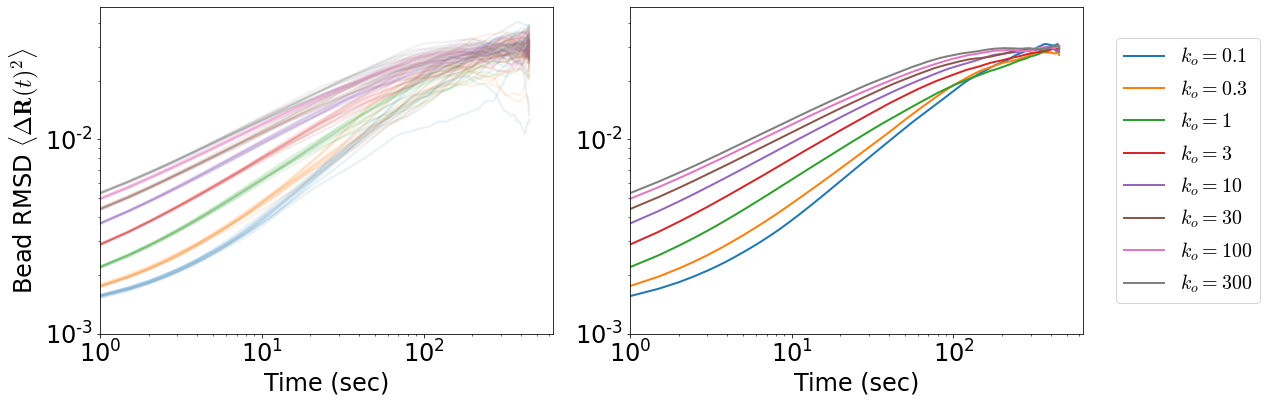

In [21]:
data_path = (ceph_path /"CondCharPaper/22-10-16_aLc1_line800_sticky55nm_kod.1-300/simulations")
colors = list(mcolors.TABLEAU_COLORS.keys())
ss_ind = 1500
end_ind = -1
start_bead = 0
end_bead = None
try:
    fig1, axarr1 = plt.subplots(1, 2, figsize=(18, 6))
    axarr1[0].sharey(axarr1[1])
    axarr1[0].sharex(axarr1[1])
    mp = re.compile('kod(\d*\.?\d+)')

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    avg_auto_corr_list = []
    std_auto_corr_list = []
    for i, pd in tqdm(enumerate(param_dirs)):
        auto_corr_list = []
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue

        for h5_data in sd_h5_data_lst:

            time_arr = h5_data['time'][:-ss_ind+end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            n_beads = com_arr.shape[0]
            auto_corr_list += [poly_bead_rmsd(com_arr)]
            _ = axarr1[0].plot(time_arr, auto_corr_list[-1].cpu(), color=colors[i], alpha=.1)
        min_length = min([len(avg) for avg in auto_corr_list])
        auto_corr_mat = torch.stack([avg[:min_length] for avg in auto_corr_list])
        
        avg_auto_corr_list += [auto_corr_mat.mean(axis=0)]
        std_auto_corr_list += [auto_corr_mat.std(axis=0)]
        
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
    
        _ = axarr1[1].plot(time_arr[:min_length], avg_auto_corr_list[-1].cpu(), color=colors[i], label=f"$ k_o = {label}$")
    
    _ = axarr1[0].set_ylabel('Bead RMSD ' + r'$\langle \Delta {\bf R}(t)^2 \rangle$')
    _ = axarr1[0].set_xlabel('Time (sec)')
    _ = axarr1[1].set_xlabel('Time (sec)')
    _ = axarr1[0].set_yscale('log')
    _ = axarr1[0].set_xscale('log')
    _ = axarr1[0].set_ylim(0.001)
    _ = axarr1[0].set_xlim(1.0)

    _ = axarr1[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

## Rheology calculations

0it [00:00, ?it/s]

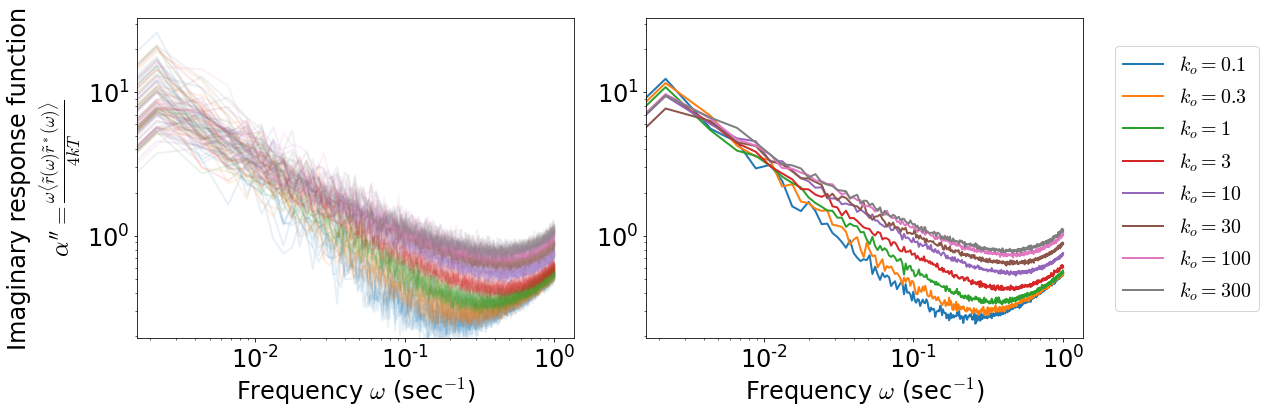

In [65]:

data_path = (ceph_path /"CondCharPaper/22-10-16_aLc1_line800_sticky55nm_kod.1-300/simulations")
colors = list(mcolors.TABLEAU_COLORS.keys())
ss_ind = 1500
end_ind = -1
start_bead = 0
end_bead = None
try:
    fig1, axarr1 = plt.subplots(1, 2, figsize=(18, 6))
    axarr1[0].sharey(axarr1[1])
    axarr1[0].sharex(axarr1[1])
    mp = re.compile('kod(\d*\.?\d+)')

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    avg_power_spec_list = []
    std_auto_corr_list = []
    fft_avg_rmsd_list = []
    for i, pd in tqdm(enumerate(param_dirs)):
        power_spec_list = []
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue

        for h5_data in sd_h5_data_lst:

            time_arr = h5_data['time'][:-ss_ind+end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            fft = torch.fft.fft(torch.from_numpy(com_arr).to(device), dim=-1)
            power_spec = torch.einsum('ijk,ijk->ik', fft, torch.conj(fft)) 
            n_beads = com_arr.shape[0]

            power_spec_list += [torch.fft.fftshift(power_spec.mean(axis=0))]
            freq = torch.fft.fftfreq(power_spec_list[-1].size(dim=0), time_arr[2]-time_arr[1])
            freqs = torch.fft.fftshift(freq)
            power_spec_list[-1]*=freqs
            _ = axarr1[0].plot(freqs, power_spec_list[-1].cpu(), color=colors[i], alpha=.1)

        min_length = min([len(avg) for avg in power_spec_list])
        power_spec_mat = torch.stack([avg[:min_length] for avg in power_spec_list])
        
        avg_power_spec_list += [power_spec_mat.mean(axis=0)]
        std_auto_corr_list += [power_spec_mat.std(axis=0)]
        
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
        freq = torch.fft.fftfreq(int(time_arr[:min_length].size), time_arr[2]-time_arr[1])
        freqs = torch.fft.fftshift(freq)
        _ = axarr1[1].plot(freqs, (avg_power_spec_list[-1]), color=colors[i], label=f"$ k_o = {label}$")
    
    _ = axarr1[0].set_ylabel('Imaginary response function\n' + r"$\alpha'' = \frac{\omega\langle \tilde{r}(\omega)\tilde{r}^*(\omega)\rangle}{4kT}$")
    _ = axarr1[0].set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
    _ = axarr1[1].set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
    _ = axarr1[0].set_yscale('log')
    _ = axarr1[0].set_xscale('log')

    _ = axarr1[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

0it [00:00, ?it/s]

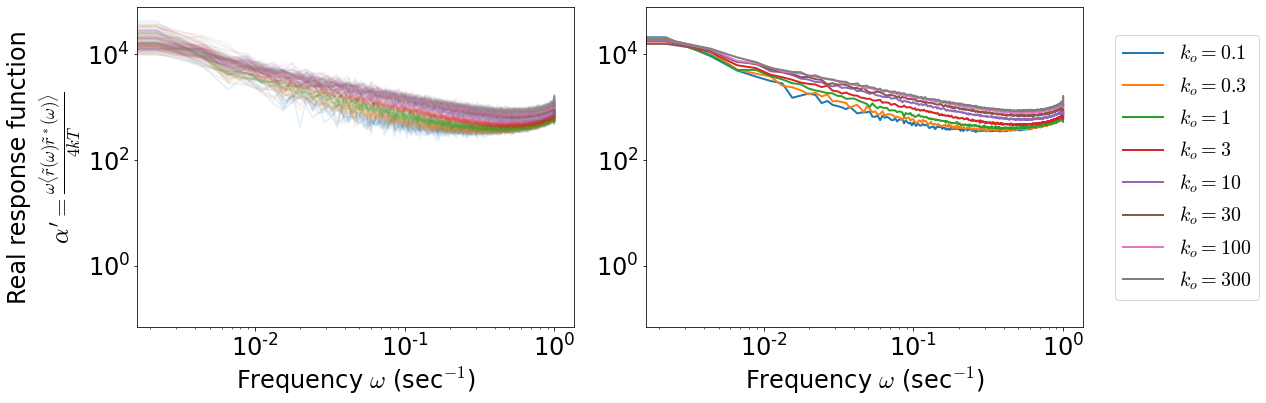

In [ ]:

data_path = (ceph_path /"CondCharPaper/22-10-16_aLc1_line800_sticky55nm_kod.1-300/simulations")
colors = list(mcolors.TABLEAU_COLORS.keys())
ss_ind = 1500
end_ind = -1
start_bead = 0
end_bead = None
try:
    fig1, axarr1 = plt.subplots(1, 2, figsize=(18, 6))
    axarr1[0].sharey(axarr1[1])
    axarr1[0].sharex(axarr1[1])
    mp = re.compile('kod(\d*\.?\d+)')

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    avg_real_resp_list = []
    std_auto_corr_list = []
    for i, pd in tqdm(enumerate(param_dirs)):
        power_spec_list = []
        im_resp_list = []
        real_resp_list = []
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue

        for h5_data in sd_h5_data_lst:

            time_arr = h5_data['time'][:-ss_ind+end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            fft = torch.fft.fft(torch.from_numpy(com_arr).to(device), dim=-1)
            power_spec = torch.einsum('ijk,ijk->ik', fft, torch.conj(fft)) 
            n_beads = com_arr.shape[0]

            power_spec_list += [torch.fft.fftshift(power_spec.mean(axis=0))]
            freq = torch.fft.fftfreq(power_spec_list[-1].size(dim=0), time_arr[2]-time_arr[1])
            freqs = torch.fft.fftshift(freq)
            im_resp_list += [freqs * power_spec_list[-1]]
            real_resp_list += [(2./np.pi) * torch.from_numpy(
                fftpack.dct(
                    fftpack.dst(im_resp_list[-1].cpu().numpy())
                )
            )]

            _ = axarr1[0].plot(freqs, real_resp_list[-1], color=colors[i], alpha=.1)
            _ = real_resp_list[-1].to(device)

        min_length = min([len(avg) for avg in real_resp_list])
        real_resp_mat = torch.stack([avg[:min_length] for avg in real_resp_list])
        
        avg_real_resp_list += [real_resp_mat.mean(axis=0)]
        # std_auto_corr_list += [power_spec_mat.std(axis=0)]
        
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
        freq = torch.fft.fftfreq(int(time_arr[:min_length].size), time_arr[2]-time_arr[1])
        freqs = torch.fft.fftshift(freq)
        _ = axarr1[1].plot(freqs, (avg_real_resp_list[-1]), color=colors[i], label=f"$ k_o = {label}$")
    
    _ = axarr1[0].set_ylabel('Real response function\n' + r"$\alpha' = \frac{\omega\langle \tilde{r}(\omega)\tilde{r}^*(\omega)\rangle}{4kT}$")
    _ = axarr1[0].set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
    _ = axarr1[1].set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
    _ = axarr1[0].set_yscale('log')
    _ = axarr1[0].set_xscale('log')

    _ = axarr1[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

0it [00:00, ?it/s]

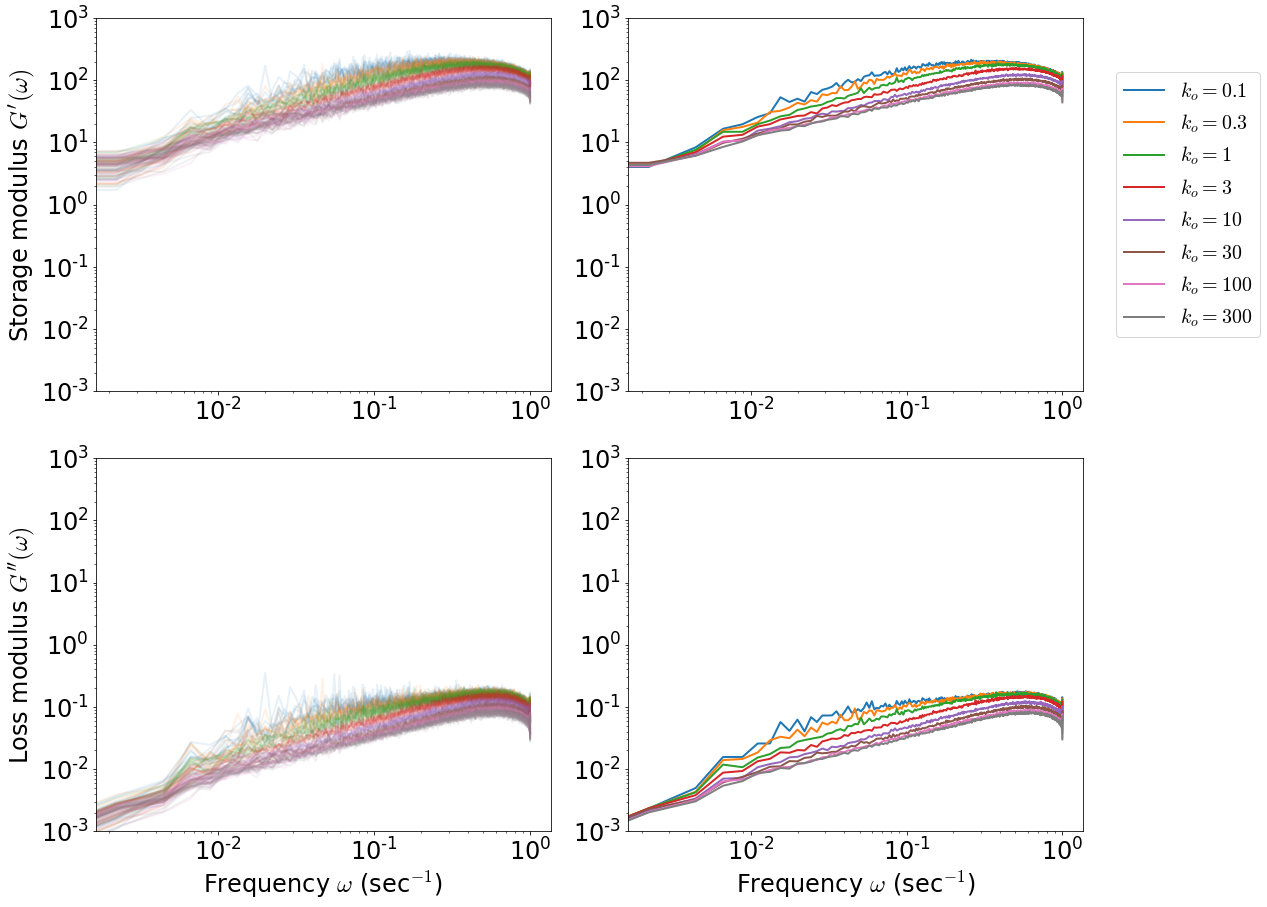

In [75]:

data_path = (ceph_path /"CondCharPaper/22-10-16_aLc1_line800_sticky55nm_kod.1-300/simulations")
colors = list(mcolors.TABLEAU_COLORS.keys())
ss_ind = 1500
end_ind = -1
start_bead = 0
end_bead = None
bead_rad = .01
try:
    fig1, axarr1 = plt.subplots(2, 2, figsize=(18, 13))
    axarr1[0,0].sharey(axarr1[0,1])
    axarr1[0,0].sharex(axarr1[0,1])
    axarr1[1,0].sharey(axarr1[1,1])
    axarr1[1,0].sharex(axarr1[1,1])
    mp = re.compile('kod(\d*\.?\d+)')

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    avg_stor_mod_list = []
    avg_loss_mod_list = []
    pre_fact = 1./(6.*np.pi*bead_rad)
    for i, pd in tqdm(enumerate(param_dirs)):
        power_spec_list = []
        stor_mod_list = []
        loss_mod_list = []
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue

        for h5_data in sd_h5_data_lst:

            time_arr = h5_data['time'][:-ss_ind+end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            fft = torch.fft.fft(torch.from_numpy(com_arr).to(device), dim=-1, norm='forward')
            power_spec = torch.einsum('ijk,ijk->ik', fft, torch.conj(fft)) 
            n_beads = com_arr.shape[0]

            power_spec_list += [torch.fft.fftshift(power_spec.mean(axis=0))]
            freq = torch.fft.fftfreq(power_spec_list[-1].size(dim=0), time_arr[2]-time_arr[1])
            freqs = torch.fft.fftshift(freq)
            im_resp = freqs * power_spec_list[-1] / (4.* .0041)
            real_resp = (2./np.pi) * torch.from_numpy(
                fftpack.dct(
                    fftpack.dst(im_resp.cpu().numpy())
                )
            ).to(device)
            resp_sqr = im_resp**2 + real_resp**2
            stor_mod_list += [pre_fact*(real_resp/resp_sqr)]
            loss_mod_list += [pre_fact*(im_resp/resp_sqr)]

            _ = axarr1[0,0].plot(freqs, stor_mod_list[-1], color=colors[i], alpha=.1)
            _ = axarr1[1,0].plot(freqs, loss_mod_list[-1], color=colors[i], alpha=.1)

        min_length = min([len(avg) for avg in stor_mod_list])
        stor_mat = torch.stack([avg[:min_length] for avg in stor_mod_list])
        loss_mat = torch.stack([avg[:min_length] for avg in loss_mod_list])
        
        avg_stor_mod_list += [stor_mat.mean(axis=0)]
        avg_loss_mod_list += [loss_mat.mean(axis=0)]
        # std_auto_corr_list += [power_spec_mat.std(axis=0)]
        
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
        freq = torch.fft.fftfreq(int(time_arr[:min_length].size), time_arr[2]-time_arr[1])
        freqs = torch.fft.fftshift(freq)
        _ = axarr1[0,1].plot(freqs, (avg_stor_mod_list[-1]), color=colors[i], label=f"$ k_o = {label}$")
        _ = axarr1[1,1].plot(freqs, (avg_loss_mod_list[-1]), color=colors[i], label=f"$ k_o = {label}$")
    
    _ = axarr1[0,0].set_ylabel('Storage modulus ' + r"$G'(\omega)$")
    _ = axarr1[1,0].set_ylabel('Loss modulus ' + r"$G''(\omega)$")
    _ = axarr1[1,0].set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
    _ = axarr1[1,1].set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
    _ = axarr1[0,0].set_ylim(.001, 1000)
    _ = axarr1[1,0].set_ylim(.001, 1000)
    _ = axarr1[0,0].set_yscale('log')
    _ = axarr1[0,0].set_xscale('log')
    _ = axarr1[1,0].set_yscale('log')
    _ = axarr1[1,0].set_xscale('log')

    _ = axarr1[0,1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

0it [00:00, ?it/s]

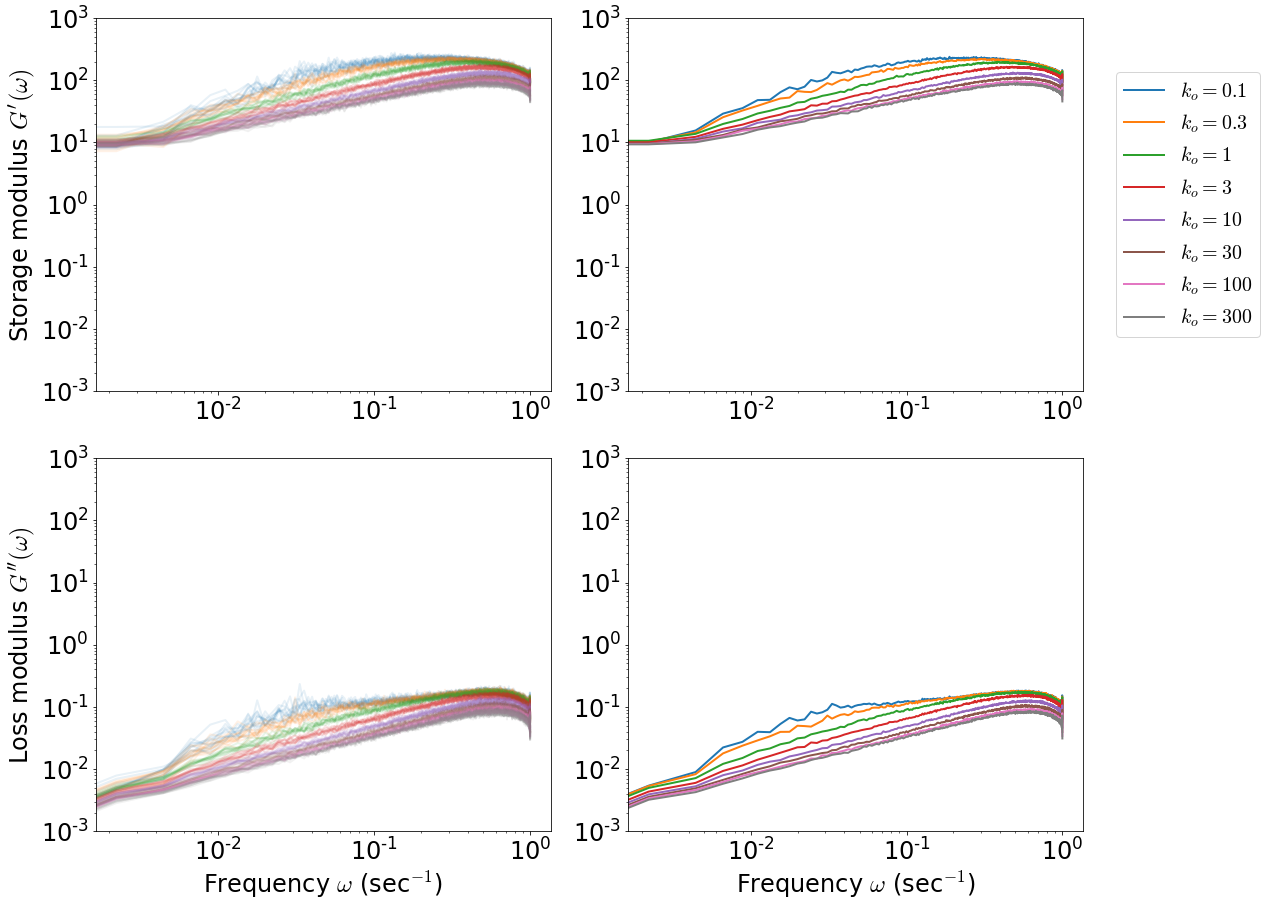

In [78]:

data_path = (ceph_path /"CondCharPaper/22-10-16_aLc1_line800_sticky55nm_kod.1-300/simulations")
colors = list(mcolors.TABLEAU_COLORS.keys())
ss_ind = 1500
end_ind = -1
start_bead = 0
end_bead = None
bead_rad = .01
try:
    fig1, axarr1 = plt.subplots(2, 2, figsize=(18, 13))
    axarr1[0,0].sharey(axarr1[0,1])
    axarr1[0,0].sharex(axarr1[0,1])
    axarr1[1,0].sharey(axarr1[1,1])
    axarr1[1,0].sharex(axarr1[1,1])
    mp = re.compile('kod(\d*\.?\d+)')

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    avg_stor_mod_list = []
    avg_loss_mod_list = []
    pre_fact = 1./(6.*np.pi*bead_rad)
    for i, pd in tqdm(enumerate(param_dirs)):
        power_spec_list = []
        stor_mod_list = []
        loss_mod_list = []
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue

        for h5_data in sd_h5_data_lst:

            time_arr = h5_data['time'][:-ss_ind+end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            com_arr -= com_arr.mean(axis=0) 
            fft = torch.fft.fft(torch.from_numpy(com_arr).to(device), dim=-1, norm='forward')
            power_spec = torch.einsum('ijk,ijk->ik', fft, torch.conj(fft)) 
            n_beads = com_arr.shape[0]

            power_spec_list += [torch.fft.fftshift(power_spec.mean(axis=0))]
            freq = torch.fft.fftfreq(power_spec_list[-1].size(dim=0), time_arr[2]-time_arr[1])
            freqs = torch.fft.fftshift(freq)
            im_resp = freqs * power_spec_list[-1] / (4.* .0041)
            real_resp = (2./np.pi) * torch.from_numpy(
                fftpack.dct(
                    fftpack.dst(im_resp.cpu().numpy())
                )
            ).to(device)
            resp_sqr = im_resp**2 + real_resp**2
            stor_mod_list += [pre_fact*(real_resp/resp_sqr)]
            loss_mod_list += [pre_fact*(im_resp/resp_sqr)]

            _ = axarr1[0,0].plot(freqs, stor_mod_list[-1], color=colors[i], alpha=.1)
            _ = axarr1[1,0].plot(freqs, loss_mod_list[-1], color=colors[i], alpha=.1)

        min_length = min([len(avg) for avg in stor_mod_list])
        stor_mat = torch.stack([avg[:min_length] for avg in stor_mod_list])
        loss_mat = torch.stack([avg[:min_length] for avg in loss_mod_list])
        
        avg_stor_mod_list += [stor_mat.mean(axis=0)]
        avg_loss_mod_list += [loss_mat.mean(axis=0)]
        # std_auto_corr_list += [power_spec_mat.std(axis=0)]
        
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
        freq = torch.fft.fftfreq(int(time_arr[:min_length].size), time_arr[2]-time_arr[1])
        freqs = torch.fft.fftshift(freq)
        _ = axarr1[0,1].plot(freqs, (avg_stor_mod_list[-1]), color=colors[i], label=f"$ k_o = {label}$")
        _ = axarr1[1,1].plot(freqs, (avg_loss_mod_list[-1]), color=colors[i], label=f"$ k_o = {label}$")
    
    _ = axarr1[0,0].set_ylabel('Storage modulus ' + r"$G'(\omega)$")
    _ = axarr1[1,0].set_ylabel('Loss modulus ' + r"$G''(\omega)$")
    _ = axarr1[1,0].set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
    _ = axarr1[1,1].set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
    _ = axarr1[0,0].set_ylim(.001, 1000)
    _ = axarr1[1,0].set_ylim(.001, 1000)
    _ = axarr1[0,0].set_yscale('log')
    _ = axarr1[0,0].set_xscale('log')
    _ = axarr1[1,0].set_yscale('log')
    _ = axarr1[1,0].set_xscale('log')

    _ = axarr1[0,1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

## $\ell_s$ scans

0it [00:00, ?it/s]

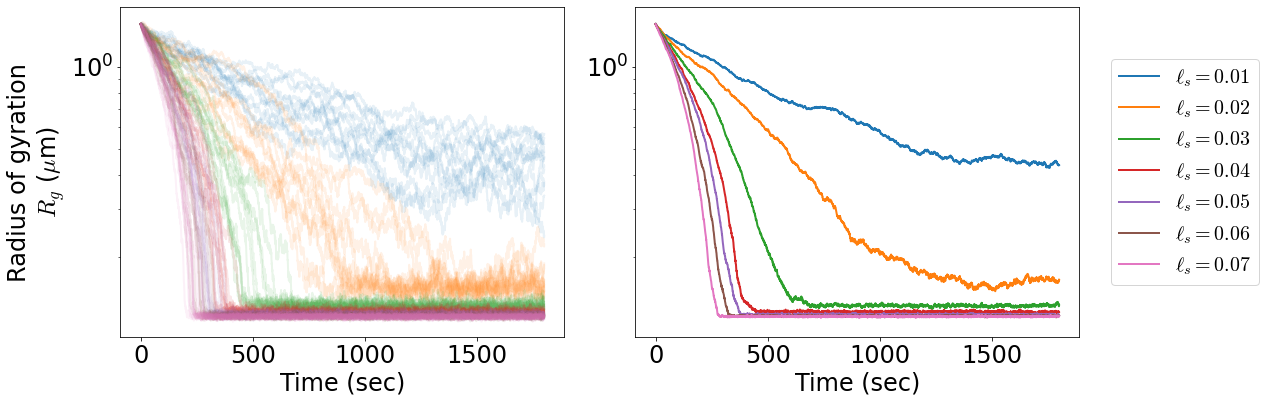

In [52]:
data_path = (ceph_path /"CondCharPaper/22-10-18_aLchr1_scan7.12_Ke30_kod3.05_line800_stickyL.01-.07/simulations")
colors = list(mcolors.TABLEAU_COLORS.keys())
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None
try:
    fig1, axarr1 = plt.subplots(1, 2, figsize=(18, 6))
    axarr1[0].sharey(axarr1[1])
    axarr1[0].sharex(axarr1[1])
    mp = re.compile('Ls(\d*\.?\d+)')

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    avg_ee_list = []
    std_ee_list = []
    for i, pd in tqdm(enumerate(param_dirs)):
        avg_ee_arrs = []
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue

        for h5_data in sd_h5_data_lst:
            time_arr = h5_data['time'][ss_ind:end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            n_beads = com_arr.shape[0]
            # ee_dist = aa.get_end_end_distance(com_arr)
            rog = aa.calc_rad_of_gyration(com_arr)
            _ = axarr1[0].plot(time_arr, rog, color=colors[i], alpha=.1)
            avg_ee_arrs += [rog.tolist()]
        min_length = min([len(avg) for avg in avg_ee_arrs])
        
        
        avg_ee_arrs = np.array([avg[:min_length] for avg in avg_ee_arrs])
        avg_ee_list += [avg_ee_arrs.mean(axis=0)]
        std_ee_list += [avg_ee_arrs.std(axis=0)]
        
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
    
        _ = axarr1[1].plot(time_arr[:min_length], avg_ee_list[-1], color=colors[i], label=f"$\ell_s = {label}$")
    
    _ = axarr1[0].set_ylabel('Radius of gyration\n' + r'$R_g$ ($\mu$m)')
    _ = axarr1[0].set_xlabel('Time (sec)')
    _ = axarr1[1].set_xlabel('Time (sec)')
    _ = axarr1[0].set_yscale('log')
    # _ = axarr1[0].set_ylim(0.1)

    _ = axarr1[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

0it [00:00, ?it/s]

[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07]


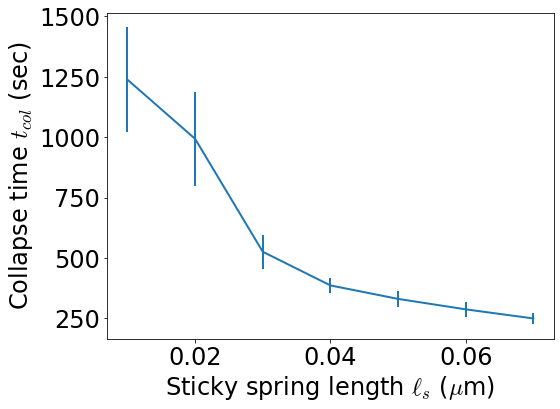

In [56]:
data_path = (ceph_path /"CondCharPaper/22-10-18_aLchr1_scan7.12_Ke30_kod3.05_line800_stickyL.01-.07/simulations")
colors = list(mcolors.TABLEAU_COLORS.keys())
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None
try:
    fig1, axarr1 = plt.subplots(1, 1, figsize=(8, 6))
    pvals = []
    collapse_times_avg = []
    collapse_times_std = []
    for i, pd in tqdm(enumerate(param_dirs)):
        pvals += [float(re.split(r'(^[^\d]+)',str(pd.name))[1:][1])]
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue
        clps_times = []
        for h5_data in sd_h5_data_lst:
            time_arr = h5_data['time'][ss_ind:end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            rog = aa.calc_rad_of_gyration(com_arr)
            clps_ind = find_steady_state_ind(rog, [-600, None])
            clps_times += [time_arr[clps_ind]]
        collapse_times_avg += [np.mean(clps_times)]
        collapse_times_std += [np.std(clps_times)]

    print(pvals)
    _ = axarr1.errorbar(pvals, collapse_times_avg, yerr=collapse_times_std )
        
    _ = axarr1.set_ylabel('Collapse time' + r" $t_{col}$ (sec)")
    _ = axarr1.set_xlabel('Sticky spring length $\ell_s$ ($\mu$m)')
    # _ = axarr1.set_yscale('log')
    # _ = axarr1.set_xscale('log')
    # _ = axarr1.set_ylim(20, 200)

    # _ = axarr1[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
    # fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

0it [00:00, ?it/s]

[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07]


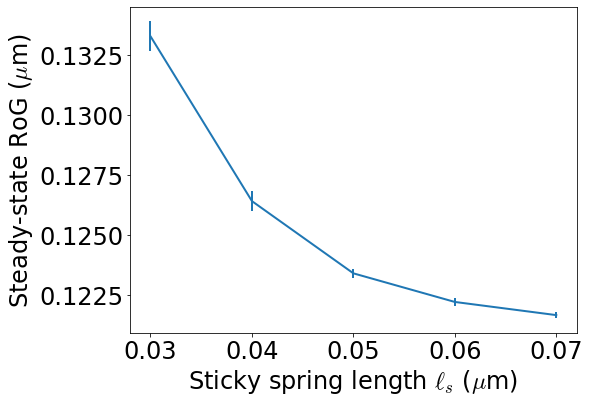

In [62]:
data_path = (ceph_path /"CondCharPaper/22-10-18_aLchr1_scan7.12_Ke30_kod3.05_line800_stickyL.01-.07/simulations")
colors = list(mcolors.TABLEAU_COLORS.keys())
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None
try:
    fig1, axarr1 = plt.subplots(1, 1, figsize=(8, 6))
    mp = re.compile('Ls(\d*\.?\d+)')

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    pvals = []
    rog_avg = []
    rog_std = []
    for i, pd in tqdm(enumerate(param_dirs)):
        pvals += [float(re.split(r'(^[^\d]+)',str(pd.name))[1:][1])]
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue
        rog_arr = []
        for h5_data in sd_h5_data_lst:
            time_arr = h5_data['time'][ss_ind:end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            rog_arr += [aa.calc_rad_of_gyration(com_arr[:,:,-600:]).mean()]
        rog_avg += [np.mean(rog_arr)]
        rog_std += [np.std(rog_arr)]
    print(pvals)

    _ = axarr1.errorbar(pvals[2:], rog_avg[2:], yerr=rog_std[2:] )
        
    _ = axarr1.set_ylabel('Steady-state RoG ($\mu$m)')
    _ = axarr1.set_xlabel('Sticky spring length $\ell_s$ ($\mu$m)')
    # _ = axarr1.set_yscale('log')
    # _ = axarr1.set_xscale('log')
    # _ = axarr1.set_ylim(100, 1500)

    # _ = axarr1[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
    # fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

0it [00:00, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

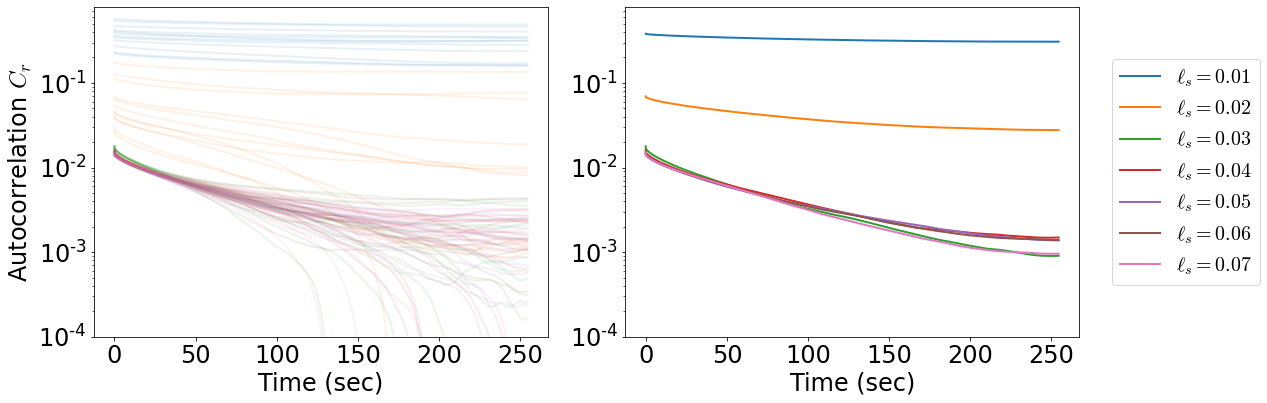

In [57]:
data_path = (ceph_path /"CondCharPaper/22-10-18_aLchr1_scan7.12_Ke30_kod3.05_line800_stickyL.01-.07/simulations")
colors = list(mcolors.TABLEAU_COLORS.keys())
ss_ind = -1023
end_ind = -1
start_bead = 0
end_bead = None
try:
    fig1, axarr1 = plt.subplots(1, 2, figsize=(18, 6))
    axarr1[0].sharey(axarr1[1])
    axarr1[0].sharex(axarr1[1])
    mp = re.compile('Ls(\d*\.?\d+)')

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    avg_auto_corr_list = []
    std_auto_corr_list = []
    for i, pd in tqdm(enumerate(param_dirs)):
        auto_corr_list = []
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue

        for h5_data in tqdm(sd_h5_data_lst):
            valid_n = int((-ss_ind+end_ind)/2)
            lag_arr = h5_data['time'][:valid_n]
            # time_arr = h5_data['time'][:-ss_ind+end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            n_beads = com_arr.shape[0]
            auto_corr_list += [poly_autocorr_fast(com_arr)[:valid_n]]
            _ = axarr1[0].plot(lag_arr, auto_corr_list[-1].cpu(), color=colors[i], alpha=.1)
        min_length = min([len(avg) for avg in auto_corr_list])
        auto_corr_mat = torch.stack([avg[:min_length] for avg in auto_corr_list])
        
        avg_auto_corr_list += [auto_corr_mat.mean(dim=0)]
        std_auto_corr_list += [auto_corr_mat.std(dim=0)]
        
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
    
        _ = axarr1[1].plot(lag_arr[:min_length], avg_auto_corr_list[-1].cpu(), color=colors[i], label=f"$\ell_s = {label}$")
    
    _ = axarr1[0].set_ylabel('Autocorrelation ' + r'$C_r$')
    _ = axarr1[0].set_xlabel('Time (sec)')
    _ = axarr1[1].set_xlabel('Time (sec)')
    # _ = axarr1[0].set_xscale('log')
    _ = axarr1[0].set_yscale('log')
    _ = axarr1[0].set_ylim(0.0001)

    _ = axarr1[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

0it [00:00, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

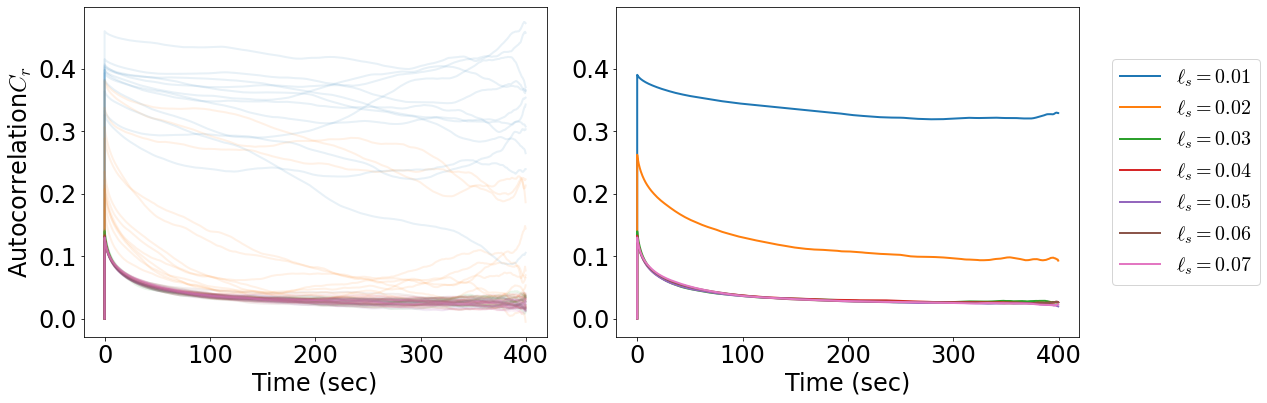

In [10]:
data_path = (ceph_path /"CondCharPaper/22-10-18_aLchr1_scan7.12_Ke30_kod3.05_line800_stickyL.01-.07/simulations")
colors = list(mcolors.TABLEAU_COLORS.keys())
ss_ind = 1600
end_ind = -1
start_bead = 0
end_bead = None
try:
    fig1, axarr1 = plt.subplots(1, 2, figsize=(18, 6))
    axarr1[0].sharey(axarr1[1])
    axarr1[0].sharex(axarr1[1])
    mp = re.compile('Ls(\d*\.?\d+)')

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    avg_auto_corr_list = []
    std_auto_corr_list = []
    for i, pd in tqdm(enumerate(param_dirs)):
        auto_corr_list = []
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue

        for h5_data in tqdm(sd_h5_data_lst):

            time_arr = h5_data['time'][:-ss_ind+end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            n_beads = com_arr.shape[0]
            auto_corr_list += [sep_autocorr(com_arr)]
            _ = axarr1[0].plot(time_arr, auto_corr_list[-1].cpu(), color=colors[i], alpha=.1)
        min_length = min([len(avg) for avg in auto_corr_list])
        auto_corr_mat = torch.stack([avg[:min_length] for avg in auto_corr_list])
        
        avg_auto_corr_list += [auto_corr_mat.mean(axis=0)]
        std_auto_corr_list += [auto_corr_mat.std(axis=0)]
        
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
    
        _ = axarr1[1].plot(time_arr[:min_length], avg_auto_corr_list[-1].cpu(), color=colors[i], label=f"$ \ell_s = {label}$")
    
    _ = axarr1[0].set_ylabel('Autocorrelation' + r'$ C_r$')
    _ = axarr1[0].set_xlabel('Time (sec)')
    _ = axarr1[1].set_xlabel('Time (sec)')
    # _ = axarr1[0].set_yscale('log')
    # _ = axarr1[0].set_ylim(0.1)

    _ = axarr1[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

0it [00:00, ?it/s]

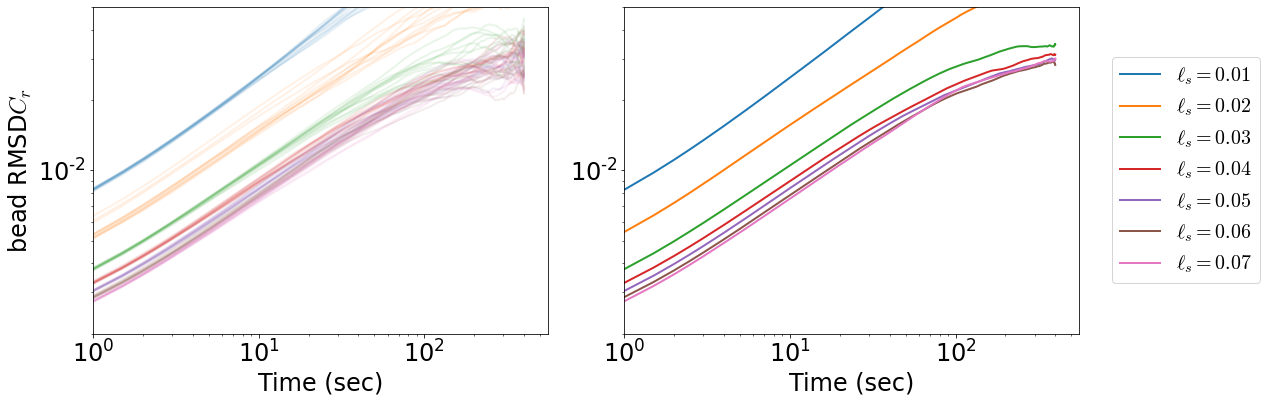

In [9]:
data_path = (ceph_path /"CondCharPaper/22-10-18_aLchr1_scan7.12_Ke30_kod3.05_line800_stickyL.01-.07/simulations")
colors = list(mcolors.TABLEAU_COLORS.keys())
ss_ind = 1600
end_ind = -1
start_bead = 0
end_bead = None
try:
    fig1, axarr1 = plt.subplots(1, 2, figsize=(18, 6))
    axarr1[0].sharey(axarr1[1])
    axarr1[0].sharex(axarr1[1])
    mp = re.compile('Ls(\d*\.?\d+)')

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    avg_auto_corr_list = []
    std_auto_corr_list = []
    for i, pd in tqdm(enumerate(param_dirs)):
        auto_corr_list = []
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue

        for h5_data in sd_h5_data_lst:

            time_arr = h5_data['time'][:-ss_ind+end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            n_beads = com_arr.shape[0]
            auto_corr_list += [poly_bead_rmsd(com_arr)]
            _ = axarr1[0].plot(time_arr, auto_corr_list[-1].cpu(), color=colors[i], alpha=.1)
        min_length = min([len(avg) for avg in auto_corr_list])
        auto_corr_mat = torch.stack([avg[:min_length] for avg in auto_corr_list])
        
        avg_auto_corr_list += [auto_corr_mat.mean(axis=0)]
        std_auto_corr_list += [auto_corr_mat.std(axis=0)]
        
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
    
        _ = axarr1[1].plot(time_arr[:min_length], avg_auto_corr_list[-1].cpu(), color=colors[i], label=f"$ \ell_s = {label}$")
    
    _ = axarr1[0].set_ylabel('bead RMSD' + r'$C_r$')
    _ = axarr1[0].set_xlabel('Time (sec)')
    _ = axarr1[1].set_xlabel('Time (sec)')
    _ = axarr1[0].set_yscale('log')
    _ = axarr1[0].set_xscale('log')
    _ = axarr1[0].set_ylim(0.002, .05)
    _ = axarr1[0].set_xlim(1.0)

    _ = axarr1[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

## Bead number scans

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


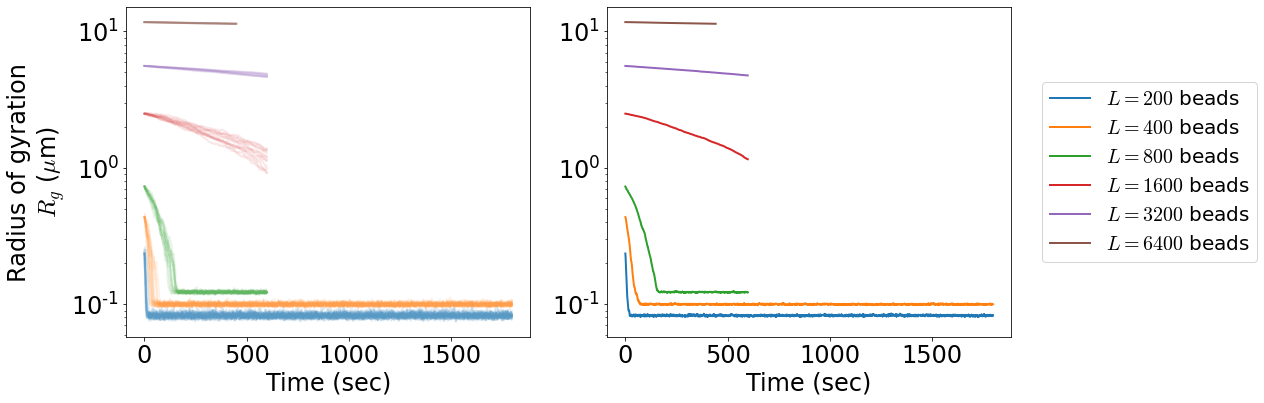

In [11]:
data_path = ceph_path / "CondCharPaper/22-09_aLc1_scan6.12_line200-6400_sticky_runs/simulations/"
colors = list(mcolors.TABLEAU_COLORS.keys())
try:
    fig1, axarr1 = plt.subplots(1, 2, figsize=(18, 6))
    axarr1[0].sharey(axarr1[1])
    axarr1[0].sharex(axarr1[1])
    mp = re.compile('line(\d*\.?\d+)')

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    
    ss_ind = 1
    end_ind = -1
    start_bead = 0
    end_bead = None


    avg_ee_list = []
    std_ee_list = []
    for i, pd in enumerate(param_dirs):
        avg_ee_arrs = []
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('simulations/s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue

        for h5_data in sd_h5_data_lst:
            time_arr = h5_data['time'][ss_ind:end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            n_beads = com_arr.shape[0]
            # ee_dist = aa.get_end_end_distance(com_arr)
            rog = aa.calc_rad_of_gyration(com_arr)
            _ = axarr1[0].plot(time_arr, rog, color=colors[i], alpha=.1)
            avg_ee_arrs += [rog.tolist()]
        min_length = min([len(avg) for avg in avg_ee_arrs])
        
        
        avg_ee_arrs = np.array([avg[:min_length] for avg in avg_ee_arrs])
        avg_ee_list += [avg_ee_arrs.mean(axis=0)]
        std_ee_list += [avg_ee_arrs.std(axis=0)]
        
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
    
        _ = axarr1[1].plot(time_arr[:min_length], avg_ee_list[-1], color=colors[i], label=f"$L = {label}$ beads")
    
    _ = axarr1[0].set_ylabel('Radius of gyration\n' + r'$R_g$ ($\mu$m)')
    _ = axarr1[0].set_xlabel('Time (sec)')
    _ = axarr1[1].set_xlabel('Time (sec)')
    _ = axarr1[0].set_yscale('log')
    # _ = axarr1[0].set_ylim(0.1)

    _ = axarr1[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

# Conclusions and Next Steps